# NicheCompass Data Analysis

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 22.01.2023
- **Date of Last Modification:** 07.09.2023

- In order to run this notebook, a trained model needs to be stored under f"../artifacts/{dataset}/models/{model_label}/{load_timestamp}".

## 1. Setup

### 1.1 Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../utils")

In [ ]:
import argparse
import gc
import os
import random
import shutil
import warnings
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import scipy.stats as stats
import seaborn as sns
import squidpy as sq
import torch
from matplotlib import gridspec
from matplotlib.pyplot import rc_context
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
# from pywaffle import Waffle

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                aggregate_obsp_matrix_per_cell_type,
                                create_cell_type_chord_plot_from_df,
                                create_new_color_dict,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                generate_enriched_gp_info_plots)

from analysis_utils import (add_cell_type_latent_cluster_emphasis,
                            add_sub_cell_type,
                            compute_cell_type_latent_clusters,
                            generate_gp_info_plots,
                            plot_physical_latent_for_cell_types,
                            plot_cell_type_latent_clusters,
                            plot_latent,
                            plot_category_in_latent_and_physical_space,
                            sankey,
                            store_top_gps_summary)

### 1.2 Define Parameters

### 1.2 Define Parameters

In [ ]:
dataset = "spatial_atac_rna_seq_mouse_brain_batch2"
#dataset = "spatial_atac_rna_seq_mouse_brain_batch2_rna_only"
#dataset = "seqfish_mouse_organogenesis_imputed"
#dataset = "vizgen_merfish_human_colon_cancer"
#dataset = "vizgen_merfish_human_ovarian_cancer"
#dataset = "vizgen_merfish_human_lung_cancer"
#dataset = "nanostring_cosmx_human_nsclc_filtered"
#dataset = "nanostring_cosmx_human_nsclc"
#dataset = "starmap_plus_mouse_cns"
#dataset = "xenium_human_breast_cancer"

#### 1.2.1 Generic Parameters

In [ ]:
## Model
# AnnData keys
adj_key = "spatial_connectivities"
spatial_key = "spatial"
sub_cell_type_key = "sub_cell_type"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
latent_key = "nichecompass_latent"
mapping_entity_key = "mapping_entity"

## Analysis
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

## Others
random_seed = 0

#### 1.2.2 Dataset-specific Parameters

In [ ]:
multimodal = False
log_norm_omics_features = False
cell_type_groups = []
latent_groups = []

if dataset == "seqfish_mouse_organogenesis_imputed":
    load_timestamp = "09082023_225056_10"
    model_label = "one-hop-norm_reference"
    counts_key = "log_normalized_counts"
    cell_type_key = "celltype_mapped_refined"
    dataset_str = "seqFISH Mouse Organogenesis Imputed"
    multimodal = False
    sample_key = "sample"
    condition_key = "batch"
    latent_leiden_resolution = 0.35
    latent_groups = ["16", "15", "4", "10", "5", "6"]
    spot_size = 0.05
    cell_type_groups = []
    multimodal = False
    samples = ["embryo2"]
elif dataset == "starmap_plus_mouse_cns":
    cell_type_key = "Main_molecular_cell_type"
    groups = "Astrocytes"
    dataset_str = "STARmap PLUS Mouse Central Nervous System"
    load_timestamp = "20062023_155306_1"
    #load_timestamp = "12062023_110439"
    #load_timestamp = "20062023_164533_42"
    model_label = "one-hop-norm_reference"
    condition_key = "batch"
    sample_key = "batch"
    latent_leiden_resolution = 0.2
    latent_cluster_spot_size = 0.2
    multimodal = False
    spot_size=0.2
    cell_type_groups = ["Microglia", "Pericytes"]
elif dataset == "visium_human_heart":
    load_timestamp = "15052023_102158"
    cell_type_key = "majority_cell_type"
    dataset_str = "Visium Human Heart"
    sample_key = "batch"
    samples = ["batch1", "batch2", "batch3"]
    condition_key = "batch"
    latent_leiden_resolution = 0.5
    latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
    latent_cluster_spot_size = 200
elif dataset == "spatial_atac_rna_seq_mouse_brain_batch2":
    load_timestamp = "13092023_174230"
    #load_timestamp = "10102023_060610_165"
    model_label = "reference"
    cell_type_key = "celltype"
    rna_cluster_key = "RNA_clusters"
    atac_cluster_key = "ATAC_clusters"
    dataset_str = "Spatial ATAC-RNA-Seq Mouse Brain"
    sample_key = "batch"
    samples = ["p22"]
    condition_key = "batch"
    latent_leiden_resolution = 0.3
    latent_cluster_spot_size = 30
    latent_groups = []
    multimodal = True
    spot_size = 30
    cell_type_groups = []
    feature_spaces = ["p22"]
    log_norm_omics_features = True
elif dataset == "spatial_atac_rna_seq_mouse_brain_batch2_rna_only":
    load_timestamp = "13092023_193001"
    model_label = "reference"
    cell_type_key = "celltype"
    rna_cluster_key = "RNA_clusters"
    atac_cluster_key = "ATAC_clusters"
    dataset_str = "Spatial ATAC-RNA-Seq Mouse Brain"
    sample_key = "batch"
    samples = ["p22"]
    condition_key = "batch"
    latent_leiden_resolution = 0.3
    latent_cluster_spot_size = 30
    latent_groups = []
    multimodal = False
    spot_size = 30
    cell_type_groups = []
    log_norm_omics_features = True
elif dataset == "nanostring_cosmx_human_nsclc_filtered":
    load_timestamp = "12062023_123411"
    load_timestamp = "12062023_123012"
    load_timestamp = "29092023_233507_103"
    model_label = "reference"
    dataset_str = "Nanostring CosMx Human NSCLC"
    condition_key = "batch"
    latent_leiden_resolution = 0.03
    latent_cluster_spot_size = 60
    sample_key = "batch"
    multimodal = False
    spot_size = 50
    cell_type_key = "cell_type"
elif dataset == "vizgen_merfish_human_colon_cancer":
    load_timestamp = "27062023_113037_2"
    model_label = "one-hop-norm_reference"
    dataset_str = "Vizgen MERFISH Human Colon Cancer"
    condition_key = "sample"
    sample_key = "batch"
    samples = ["batch1", "batch2"]
    latent_leiden_resolution = 0.5
    latent_cluster_spot_size = 30
elif dataset == "vizgen_merfish_human_ovarian_cancer":
    load_timestamp = "13062023_131002"
    load_timestamp = "27062023_113037_2"
    model_label = "one-hop-norm_reference"
    latent_leiden_resolution = 0.2
    latent_cluster_spot_size = 0.03
    dataset_str = "Vizgen MERFISH Human Ovarian Cancer"
    condition_key = "batch"
    sample_key = "batch"
    spot_size = 30
    cell_type_key = "cell_type"
elif dataset == "vizgen_merfish_human_lung_cancer":
    load_timestamp = "13062023_131002"
    load_timestamp = "19062023_140621_1"
    model_label = "one-hop-norm_reference"
    latent_leiden_resolution = 0.2
    latent_cluster_spot_size = 0.03
    dataset_str = "Vizgen MERFISH Human Lung Cancer"
    condition_key = "batch"
    sample_key = "batch"
    spot_size = 30
    cell_type_key = "cell_type"
elif dataset == "xenium_human_breast_cancer":
    load_timestamp = "28082023_182430_3" # 12 neighbors
    load_timestamp = "26102023_153021"
    # load_timestamp = "20062023_120357_1" # 4 neighbors
    load_timestamp = "03112023_124628"
    model_label = "reference"
    latent_leiden_resolution = 0.2
    latent_cluster_spot_size = 0.03
    dataset_str = "Xenium Human Breast Cancer"
    condition_key = "batch"
    sample_key = "batch"
    spot_size = 30
    cell_type_key = "cell_states"
elif dataset == "nanostring_cosmx_human_nsclc":
    load_timestamp = "30092023_031623_104"
    model_label = "reference"
    latent_leiden_resolution = 0.4
    latent_cluster_spot_size = 0.03
    dataset_str = "nanoString CosMx Human NSCLC"
    condition_key = "batch"
    sample_key = "batch"
    spot_size = 30
    cell_type_key = "cell_type"
    
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"

### 1.3 Run Notebook Setup

In [ ]:
sc.set_figure_params(figsize=(6, 6))
sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

### 1.4 Configure Paths and Create Directories

In [ ]:
# Define paths
figure_folder_path = f"../artifacts/{dataset}/figures/{model_label}/{load_timestamp}"
model_folder_path = f"../artifacts/{dataset}/models/{model_label}/{load_timestamp}"
result_folder_path = f"../artifacts/{dataset}/results/{model_label}/{load_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
ga_data_folder_path = "../datasets/ga_data"
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(result_folder_path, exist_ok=True)

## 2. Model

### 2.1 Load Model

In [ ]:
if model_label == "sample_integration_method_benchmarking":
    model_folder_path = f"{model_folder_path}/run{run_number}"

In [ ]:
if multimodal:
    model = NicheCompass.load(dir_path=model_folder_path,
                              adata=None,
                              adata_file_name=f"{dataset}_{model_label}.h5ad",
                              adata_atac=None,
                              adata_atac_file_name=f"{dataset}_{model_label}_atac.h5ad",
                              gp_names_key=gp_names_key)
else:
    # Load trained model
    model = NicheCompass.load(dir_path=model_folder_path,
                              adata=None,
                              adata_file_name=f"{dataset}_{model_label}.h5ad",
                              gp_names_key=gp_names_key)

In [ ]:
model.adata.uns[gp_names_key] = np.array([gp for gp in model.adata.uns[gp_names_key] if not "Add-on " in gp])
model.adata.uns[active_gp_names_key] = np.array([gp for gp in model.adata.uns[active_gp_names_key] if not "Add-on " in gp])
model.adata.uns[gp_names_key] = np.array([gp.replace(" ", "_") for gp in model.adata.uns[gp_names_key]])
model.adata.uns[active_gp_names_key] = np.array([gp.replace(" ", "_") for gp in model.adata.uns[active_gp_names_key]])

## 3. Analysis

In [ ]:
# Check number of active gene programs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

In [ ]:
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True][20:]

In [ ]:
model.add_active_gp_scores_to_obs()

In [ ]:
if dataset == "spatial_atac_rna_seq_mouse_brain_batch2":
    cell_type_df = pd.read_csv(f"{srt_data_gold_folder_path}/spatial_atac_rna_seq_mouse_brain_batch2_cell_type_annotations.csv", index_col=0)
    cell_type_df.rename({"predicted.celltype": "celltype"}, axis=1, inplace=True)
    cell_type_df.drop("ATAC_clusters", axis=1, inplace=True)
    model.adata.obs = model.adata.obs.merge(cell_type_df, left_index=True, right_index=True, how="left")

### 3.1 Analyze Latent Manifold

In [ ]:
samples = model.adata.obs[sample_key].unique().tolist()

In [ ]:
if mapping_entity_key in model.adata.obs:
    if model.adata.obs[mapping_entity_key].nunique() > 1:
        # Plot mapping entities in latent and physical space
        mapping_entity_colors = create_new_color_dict(
            adata=model.adata,
            cat_key=mapping_entity_key)

        save_fig = True
        file_path = f"{figure_folder_path}/" \
                    "mapping_entities_latent_physical_space.svg"

        plot_category_in_latent_and_physical_space(
            adata=model.adata,
            plot_label="Mapping Entities",
            cat_key=mapping_entity_key,
            groups=None,
            sample_key=sample_key,
            samples=samples,
            cat_colors=mapping_entity_colors,
            size=(720000 / len(model.adata)),
            spot_size=spot_size,
            save_fig=save_fig,
            file_path=file_path)

In [ ]:
# Plot batches in latent and physical space
condition_colors = create_new_color_dict(
    adata=model.adata,
    color_palette="batch",
    cat_key=condition_key)

save_fig = True
file_path = f"{figure_folder_path}/" \
            "batches_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Batches",
    cat_key=condition_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=condition_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [ ]:
# Plot cell types in latent and physical space
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    color_palette="cell_type_30",
    cat_key=cell_type_key)

if dataset == "spatial_atac_rna_seq_mouse_brain_batch2":
    cell_type_colors["CA3GL"] = "#1f77b4"
    cell_type_colors["D1MSN"] = "#ff7f0e"
    cell_type_colors["LSXGA"] = "#279e68"
    cell_type_colors["MXD"] = "#d62728"
    cell_type_colors["STRGA"] = "#aa40fc"

save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Cell Types",
    cat_key=cell_type_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=cell_type_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)

In [ ]:
if len(cell_type_groups) > 0:
    # Plot cell type groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(cell_type_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [ ]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    color_palette="default",
    cat_key=latent_cluster_key)

In [ ]:
plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Niches",
    cat_key=latent_cluster_key,
    groups=None,
    sample_key=sample_key,
    samples=samples,
    cat_colors=latent_cluster_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=False,
    file_path=file_path)

In [ ]:
if dataset == "spatial_atac_rna_seq_mouse_brain_batch2":
    
    # Compute latent Leiden subclustering
    sc.tl.leiden(adata=model.adata,
                 resolution=0.05,
                 key_added=latent_cluster_key,
                 restrict_to=(latent_cluster_key, ["7"]),
                 neighbors_key=latent_key)
    sc.tl.leiden(adata=model.adata,
             resolution=0.05,
             key_added=latent_cluster_key,
             restrict_to=(latent_cluster_key, ["8"]),
             neighbors_key=latent_key)
    sc.tl.leiden(adata=model.adata,
             resolution=0.05,
             key_added=latent_cluster_key,
             restrict_to=(latent_cluster_key, ["6"]),
             neighbors_key=latent_key)
    
    # Plot rna clusters in latent and physical space
    rna_cluster_colors = create_new_color_dict(
        adata=model.adata,
        color_palette="cell_type_20",
        cat_key=rna_cluster_key)

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                "rna_clusters_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="RNA clusters",
        cat_key=rna_cluster_key,
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=rna_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    # Plot atac clusters in latent and physical space
    atac_cluster_colors = create_new_color_dict(
        adata=model.adata,
        color_palette="cell_type_30",
        cat_key=atac_cluster_key)

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                "atac_clusters_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="ATAC clusters",
        cat_key=atac_cluster_key,
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=atac_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    gp_resign = True # True
    
    niche_annotation_dict = {
        "0":"Sox5 GP/Taf1 GP+ L5-L6",
        "1":"Foxa1 GP/Id3 GP+ L6a-L6b",
        "2":"Meis2 GP/Ebf1 GP+ STR_ACB_core",
        "3":"Hlf GP/Neurod2 GP+ L1_L4_vasc_olg",
        "4":"Addon16 GP/Irf8 GP+ STR_caudoputamen_lateral",
        "5":"Nr1i3 GP/Lmx1a GP+ L1-L4",
        "6,0":"Pax2 GP/L-Glutamine GP+ L5-L6",
        "6,1":"Zbtb7a GP/Myf5 GP+ L5",
        "7,0":"Gfi1b GP/Ep300 GP+ STR_caudoputamen_medial",
        "7,1":"Neurog3 GP/Nkx2-2 GP+ Anterior_commisure",
        "8,0":"Pitx3 GP/Cadm1 GP+ STR_ACB_shell",
        "8,1":"Usf2 GP/Lmo4 GP+ islm_Major_island_of_Calleja",
        "9":"Rps19 GP/Nfya GP+ Corpus_callosum",
        "10":"Plxna2 GP/Hoxb1 GP+ L2-L3",
        "11":"Smad3 GP/Col1a2 GP+ L1",
        "12":"Klf10 GP/Crx GP+ Lateral_septum_complex",
        "13":"Lmo2 GP/Nkx6-1 GP+ Lateral_septal_nucleus",
        "14":"L5-L6",
        "15":"Dach1 GP/Pitx3 GP+ STR_medial",
        "16":"Bcl11a GP/Brca1 GP+ Lateral_ventricle"}

    model.adata.obs["niche"] = model.adata.obs[latent_cluster_key].map(niche_annotation_dict)
    latent_cluster_colors = create_new_color_dict(
        adata=model.adata,
        cat_key=latent_cluster_key)
    latent_cluster_colors["7,0"] = "#7d87b9"
    latent_cluster_colors["4"] = "#4a6fe3"
    latent_cluster_colors["2"] = "#023fa5"
    latent_cluster_colors["1"] = "#DAB6C4"
    latent_cluster_colors["15"] = "#9EB9F3"
    latent_cluster_colors["7,1"] = "#9D88A2"
    latent_cluster_colors["13"] = "#FF9CDA"
    latent_cluster_colors["8,1"] = "#CE5A57"
    niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}
    
    model.adata.obs["niche_abr"] = model.adata.obs["niche"].apply(lambda x: x.split("GP+ ")[1].replace(" ", "\n") if "GP+ " in x else x)
    niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}
    niche_abreviated_colors = {}

    for key, value in niche_colors.items():
        if "GP+ " in key:
            niche_abreviated_colors[key.split("GP+ ")[1].replace(" ", "\n")] = value
        else:
            niche_abreviated_colors[key] = value
    
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "niches_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    sc.tl.dendrogram(adata=model.adata,
                     use_rep="nichecompass_latent",
                     linkage_method="ward",
                     groupby="niche")

    fig, (ax) = plt.subplots(1, 1, figsize=(3, 8))
    sc.pl.dendrogram(
        adata=model.adata,
        groupby="niche",
        orientation="left",
        ax=ax,
        save="dendrogram_nichecompass_latent.svg")
    plt.show()
    
    gps = [ 
        "Foxa1_TF_target_genes_GP", "Id3_TF_target_genes_GP",
        "Plxna2_ligand_receptor_target_gene_GP", "Hoxb1_TF_target_genes_GP",
        "Sox5_TF_target_genes_GP", "Taf1_TF_target_genes_GP", # Xanthine_metabolite_enzyme_sensor_GP    
        "Zbtb7a_TF_target_genes_GP", "Myf5_TF_target_genes_GP",
        "Pax2_TF_target_genes_GP", "L-Glutamine_metabolite_enzyme_sensor_GP",
        "Nr1i3_TF_target_genes_GP", "Lmx1a_TF_target_genes_GP",
        "Hlf_TF_target_genes_GP", "Neurod2_TF_target_genes_GP",
        "Add-on_16_GP", "Irf8_TF_target_genes_GP",
        "Meis2_TF_target_genes_GP", "Ebf1_TF_target_genes_GP",
        "Gfi1b_TF_target_genes_GP", "Ep300_TF_target_genes_GP",
        "Rps19_ligand_receptor_target_gene_GP", "Nfya_TF_target_genes_GP",
        "Neurog3_TF_target_genes_GP", "Nkx2-2_TF_target_genes_GP",
        "Lmo2_TF_target_genes_GP", "Nkx6-1_TF_target_genes_GP",
        "Klf10_TF_target_genes_GP", "Crx_TF_target_genes_GP",
        "Smad3_TF_target_genes_GP", "Col1a2_ligand_receptor_target_gene_GP",
        "Bcl11a_TF_target_genes_GP", "Brca1_TF_target_genes_GP", # Draxin_ligand_receptor_target_gene_GP
        "Usf2_TF_target_genes_GP", "Lmo4_TF_target_genes_GP",
        "Pitx3_TF_target_genes_GP", "Cadm1_ligand_receptor_target_gene_GP",
        "Dach1_TF_target_genes_GP", "Pitx3_TF_target_genes_GP",
    ]
    
    resign_gps = [
        "Taf1_TF_target_genes_GP",
        "Zbtb7a_TF_target_genes_GP",
        "Meis2_TF_target_genes_GP",
        "Ebf1_TF_target_genes_GP",
        "Neurod2_TF_target_genes_GP",
        "Nr1i3_TF_target_genes_GP",
        "Hlf_TF_target_genes_GP",
        "L-Glutamine_metabolite_enzyme_sensor_GP",
        "Gfi1b_TF_target_genes_GP",
        "Ep300_TF_target_genes_GP",
        "Pitx3_TF_target_genes_GP",
        "Cadm1_ligand_receptor_target_gene_GP",
        "Usf2_TF_target_genes_GP",
        "Lmo4_TF_target_genes_GP",
        "Rps19_ligand_receptor_target_gene_GP",
        "Nfya_TF_target_genes_GP",
        "Lmo2_TF_target_genes_GP",
        "Pitx3_TF_target_genes_GP",
        "Brca1_TF_target_genes_GP",
        "Bcl11a_TF_target_genes_GP",
        "Nkx6-1_TF_target_genes_GP",
        "Klf10_TF_target_genes_GP",
        "Dach1_TF_target_genes_GP",
        "Pitx3_TF_target_genes_GP"]
    
    if gp_resign:
        for gp in resign_gps:
            model.adata.obs[gp] = -1 * model.adata.obs[gp]
            
    df = model.adata.obs[["niche"] + gps].groupby("niche").mean()
    df = df.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::-1])

    scaler = MinMaxScaler()
    normalized_columns = scaler.fit_transform(df)
    normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
    normalized_df.index = df.index
    normalized_df.columns = [col.split("_lig")[0].split("_met")[0].split("_TF")[0].replace("Add-on_16_GP", "Addon16").replace("_acid", " acid") + " GP" for col in normalized_df.columns]

    plt.figure(figsize=(13, 6))  # Set the figure size
    ax = sns.heatmap(normalized_df,
                cmap='viridis',
                annot=False,
                linewidths=0)
    plt.xticks(rotation=45,
               fontsize=10,
               ha="right"
              )
    plt.xlabel("Gene Programs", fontsize=16)
    plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
                bbox_inches="tight")
    
    plt.figure(figsize=(13, 6))  # Set the figure size
    ax = sns.heatmap(normalized_df,
                cmap='viridis',
                annot=False,
                linewidths=0,
                cbar_kws={"orientation": "horizontal", "location": "bottom", "shrink": 0.4})
    plt.xticks([])
    plt.savefig(f"{figure_folder_path}/heatmap_colorbar.svg",
                bbox_inches="tight")
    
    tmp = pd.crosstab(model.adata.obs["niche"],model.adata.obs['batch'], normalize='index')
    tmp = tmp.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::])
    tmp.index = [gp_name.split("+ ")[1] if "+" in gp_name else gp_name for gp_name in tmp.index.tolist()]
    ax = tmp.plot.barh(color=condition_colors, stacked=True, figsize=(6, 10)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.yticks(fontsize=20)
    plt.xlabel("Data Source Proportions", fontsize=20)
    plt.savefig(f"{figure_folder_path}/niche_batch_proportions.svg", bbox_inches='tight')

    tmp = pd.crosstab(model.adata.obs["niche"], model.adata.obs[cell_type_key], normalize='index')
    tmp = tmp.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::])
    ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 10)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.yticks(fontsize=16)
    plt.xlabel("Cell Type Proportions", fontsize=16)
    plt.savefig(f"{figure_folder_path}/niche_cell_type_proportions.svg", bbox_inches='tight')
    
    sc.tl.dendrogram(adata=model.adata,
                         var_names=gps,
                         linkage_method="single",
                         groupby="niche")

    fig, (ax) = plt.subplots(1, 1, figsize=(3, 8))
    sc.pl.dendrogram(
        adata=model.adata,
        groupby="niche",
        orientation="left",
        ax=ax)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(17, 21))
    sankey(
        x=model.adata.obs[cell_type_key],
        y=model.adata.obs["niche_abr"],
        title="Cell Type to Niche Mapping",
        title_left="Cell Type",
        title_right="Niche",
        ax=ax,
        fontsize="16",  # "xx-small",
        #left_order=model.adata.obs[cell_type_key].unique().tolist(),
        colors=cell_type_colors,
        alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{figure_folder_path}/sankey_cell_type_to_niche.svg")
    plt.show()
    
    fig, ax = plt.subplots(figsize=(17, 21))
    sankey(
        x=model.adata.obs[atac_cluster_key],
        y=model.adata.obs["niche_abr"],
        title="ATAC Cluster to Niche Mapping",
        title_left="Annotated ATAC Cluster",
        title_right="Niche",
        ax=ax,
        fontsize="16",  # "xx-small",
        #left_order=model.adata.obs[cell_type_key].unique().tolist(),
        colors=atac_cluster_colors,
        alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{figure_folder_path}/sankey_atac_cluster_to_niche.svg")
    plt.show()
    
    fig, axs = plt.subplots(nrows=2,
                                ncols=2,
                                figsize=(15, 15))

    # Lmo4 TF & Target Gene Peaks
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Lmo4_TF_target_genes_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Lmo4",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    sc.pl.spatial(
        adata=model.adata,
        color="Lmo4",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Lmo4",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)
    
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr11:70029079-70029942",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"chr11:70029079-70029942",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr11:70021137-70021886",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="chr11:70021137-70021886",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/lmo4_gp_genes_peaks.svg",
                bbox_inches="tight")
    
    fig, axs = plt.subplots(nrows=6,
                                ncols=2,
                                figsize=(25, 25))

    # Lmo4 TF & Target Gene Peaks
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Add-on_16_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Add-on 16",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    sc.pl.spatial(
        adata=model.adata,
        color="Scn4b",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Scn4b",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)
    
    sc.pl.spatial(
        adata=model.adata,
        color="Gm17428",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Gm17428",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Rgs9",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Rgs9",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    
    sc.pl.spatial(
        adata=model.adata,
        color="Sh3rf2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Sh3rf2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Syndig1l",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Syndig1l",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)
    
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr3:65228350-65229095",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"chr3:65228350-65229095",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr8:63129065-63129762",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="chr8:63129065-63129762",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 1],
        show=False)
    
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr8:108813542-108814304",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="chr8:108813542-108814304",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[4, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr14:29539717-29540617",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="chr14:29539717-29540617",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[4, 1],
        show=False)
    
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr13:54093213-54094097",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="chr13:54093213-54094097",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[5, 0],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/addon16_gp_genes_peaks.svg",
                bbox_inches="tight")
    
    fig, axs = plt.subplots(nrows=4,
                                ncols=2,
                                figsize=(15, 15))
    
    model.adata.obs["Rps19_ligand_receptor_target_gene_GP_sign_corrected"] = -1 *  model.adata.obs["Rps19_ligand_receptor_target_gene_GP"]

    # Lmo4 TF & Target Gene Peaks
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Rps19_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Rps19 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    sc.pl.spatial(
        adata=model.adata,
        color="Rps19",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Rps19",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)
    
    sc.pl.spatial(
        adata=model.adata,
        color="Cd82",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cd82",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Scd2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Scd2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    
    sc.pl.spatial(
        adata=model.adata,
        color="Ndrg1",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Ndrg1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Mical2",
        use_raw=False,
        color_map="YlOrBr",
        spot_size=spot_size,
        title=f"Mical2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)    
    
    sc.pl.spatial(
        adata=model.adata,
        color="Enpp2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Enpp2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/rps19_gp_genes.svg",
                bbox_inches="tight")
    
    fig, axs = plt.subplots(nrows=3,
                                ncols=2,
                                figsize=(15, 15))

    # Lmo4 TF & Target Gene Peaks
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Usf2_TF_target_genes_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Usf2 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    sc.pl.spatial(
        adata=model.adata,
        color="Prkar2b",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Prkar2b",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)
    
    sc.pl.spatial(
        adata=model.adata,
        color="Apc",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Apc",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Pou2f1",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Pou2f1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr18:34247310-34248119",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"chr18:34247310-34248119",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr1:165934747-165935645",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"chr1:165934747-165935645",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)    

    plt.show()
    fig.savefig(f"{figure_folder_path}/usf2_gp_genes.svg",
                bbox_inches="tight")
    
    fig, axs = plt.subplots(nrows=3,
                            ncols=2,
                            figsize=(20, 15))

    # L-Glutamine_metabolite_enzyme_sensor_GP
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="L-Glutamine_metabolite_enzyme_sensor_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"L-Glutamine_metabolite_enzyme_sensor_GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    # Sensor
    sc.pl.spatial(
        adata=model.adata,
        color="Slc38a2",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Slc38a2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)
    
    # Sensor
    sc.pl.spatial(
        adata=model.adata,
        color="Slc38a1",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Slc38a1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    # Enzyme
    sc.pl.spatial(
        adata=model.adata,
        color="Gls",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Gls",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    
    # Enzyme
    sc.pl.spatial(
        adata=model.adata,
        color="Glul",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Glul",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    # Enzyme
    sc.pl.spatial(
        adata=model.adata,
        color="Gmps",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Gmps",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/l-glutamine_gp_genes.svg",
                bbox_inches="tight")
    
    fig, axs = plt.subplots(nrows=3,
                            ncols=2,
                            figsize=(20, 15))

    # L-Aspartic_acid_metabolite_enzyme_sensor_GP
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Add-on_89_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Add-on_89_GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    sc.pl.spatial(
        adata=model.adata,
        color="Mobp",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Mobp",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)
    
    sc.pl.spatial(
        adata=model.adata,
        color="Tspan2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Tspan2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/addon89_gp_genes.svg",
                bbox_inches="tight")
    
    network_df = compute_communication_gp_network(
        gp_list=["Rps19_ligand_receptor_target_gene_GP", "L-Glutamine_metabolite_enzyme_sensor_GP"],
        model=model,
        group_key="niche_abr", # celltype
        n_neighbors=90)
        
    rps_network_df = network_df[network_df["edge_type"] == "Rps19_ligand_receptor_target_gene_GP"]
    lglutamine_network_df = network_df[network_df["edge_type"] == "L-Glutamine_metabolite_enzyme_sensor_GP"]
    
    visualize_communication_gp_network(
        adata=model.adata,
        network_df=rps_network_df,
        figsize=(14, 8),
        cat_colors=niche_abreviated_colors,
        edge_type_colors=["#1f77b4"], 
        cat_key="niche_abr",
        save=True,
        save_path=f"{figure_folder_path}/gp_network_rps.svg",
        )

    visualize_communication_gp_network(
    adata=model.adata,
    network_df=lglutamine_network_df,
    figsize=(15, 7),
    cat_colors=niche_abreviated_colors,
    edge_type_colors=["#ff7f0e"],
    cat_key="niche_abr",
    save=True,
    save_path=f"{figure_folder_path}/gp_network_lglutamine.svg",
    )
    
    model.model.features_idx_dict_["target_reconstructed_rna_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["target_masked_rna_idx"], model.model.features_idx_dict_["target_unmasked_rna_idx"])))
    model.model.features_idx_dict_["source_reconstructed_rna_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["source_masked_rna_idx"], model.model.features_idx_dict_["source_unmasked_rna_idx"])))
    model.model.features_idx_dict_["target_reconstructed_atac_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["target_masked_atac_idx"], model.model.features_idx_dict_["target_unmasked_atac_idx"])))
    model.model.features_idx_dict_["source_reconstructed_atac_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["source_masked_atac_idx"], model.model.features_idx_dict_["source_unmasked_atac_idx"])))

    output = model.get_omics_decoder_outputs(
                    adata=model.adata,
                    only_active_gps=True,
                    node_batch_size=2048)

    target_genes = ["Lmo4", "Gm17428", "Rgs9", "Sh3rf2", "Syndig1l", "Cd82", "Scd2", "Ndrg1", "Mical2", "Enpp2", "Slc1a2"]
    for gene in target_genes:
        model.adata.obs[f"{gene}_rec"] = output["target_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]

    source_genes = ["Scn4b", "Aspa", "Asrgl1", "Prkar2b", "Apc", "Pou2f1", "Rps19"]
    for gene in source_genes:
        model.adata.obs[f"{gene}_rec"] = output["source_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]

    target_peaks = ["chr8:63129065-63129762"]
    for peak in target_peaks:
        model.adata_atac.obs[f"{peak}_rec"] = output["target_atac_nb_means"][:, model.adata_atac.var_names.tolist().index(peak)]

    source_peaks = ["chr18:34247310-34248119", "chr1:165934747-165935645", "chr3:65228350-65229095", "chr8:108813542-108814304", "chr14:29539717-29540617", "chr13:54093213-54094097", "chr11:70029079-70029942", "chr11:70021137-70021886"]
    for peak in source_peaks:
        model.adata_atac.obs[f"{peak}_rec"] = output["source_atac_nb_means"][:, model.adata_atac.var_names.tolist().index(peak)]

    # Reconstructed genes
    fig, axs = plt.subplots(nrows=len(target_genes + source_genes),
                            ncols=1,
                            figsize=(10, 10 * len(target_genes + source_genes)))

    color_map = "RdPu"
    for i, gene in enumerate(target_genes + source_genes):
        sc.pl.spatial(
            adata=model.adata,
            color=f"{gene}_rec",
            color_map=color_map,
            spot_size=spot_size,
            title=f"{gene}_rec",
            legend_loc=None,
            colorbar_loc="bottom",
            ax=axs[i],
            show=False)    

    plt.show()
    fig.savefig(f"{figure_folder_path}/reconstructed_genes.svg",
            bbox_inches="tight")
    
    # Reconstructed peaks
    fig, axs = plt.subplots(nrows=len(target_peaks + source_peaks),
                            ncols=1,
                            figsize=(10, 10 * len(target_peaks + source_peaks)))

    color_map = "RdPu"
    for i, gene in enumerate(target_peaks + source_peaks):
        sc.pl.spatial(
            adata=model.adata_atac,
            color=f"{gene}_rec",
            color_map=color_map,
            spot_size=spot_size,
            title=f"{gene}_rec",
            legend_loc=None,
            colorbar_loc="bottom",
            ax=axs[i],
            show=False)    

    plt.show()
    fig.savefig(f"{figure_folder_path}/reconstructed_peaks.svg",
                bbox_inches="tight")
    
    fig, axs = plt.subplots(nrows=5,
                                    ncols=2,
                                    figsize=(25, 25))

    # Add-on 89 GP
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Add-on_89_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Add-on 89",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    sc.pl.spatial(
        adata=model.adata,
        color="Mobp",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Mobp",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    sc.pl.spatial(
        adata=model.adata,
        color="Tspan2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Tspan2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Pllp",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Pllp",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    sc.pl.spatial(
        adata=model.adata,
        color="Trf",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Trf",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Pdlim2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Pdlim2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)

    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr1:24612403-24613300",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"chr1:24612403-24613300",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr1:172349675-172350564",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="chr1:172349675-172350564",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 1],
        show=False)


    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr4:48629122-48629953",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="chr4:48629122-48629953",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[4, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr14:54935868-54936644",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="chr14:54935868-54936644",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[4, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/addon89_gp_genes_peaks.svg",
                bbox_inches="tight")

    fig, axs = plt.subplots(nrows=5,
                            ncols=2,
                            figsize=(25, 25))

    model.adata.obs["Sfrp1_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Sfrp1_ligand_receptor_target_gene_GP"]

    # Sfrp1 GP
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Sfrp1_ligand_receptor_target_gene_GP_sign_corrected",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Sfrp1 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    sc.pl.spatial(
        adata=model.adata,
        color="Sfrp1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Sfrp1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    sc.pl.spatial(
        adata=model.adata,
        color="Tpx2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Tpx2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Fzd2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Fzd2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    sc.pl.spatial(
        adata=model.adata,
        color="Palld",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Palld",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)

    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr11:102603868-102604697",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"chr11:102603868-102604697",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr13:99458804-99459599",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="chr13:99458804-99459599",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 1],
        show=False)


    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr13:99444371-99445164",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="chr13:99444371-99445164",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[4, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr13:99514802-99515661",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="chr13:99514802-99515661",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[4, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/sfrp1_gp_genes_peaks.svg",
                bbox_inches="tight")

    fig, axs = plt.subplots(nrows=5,
                            ncols=2,
                            figsize=(25, 25))

    # Sfrp1 GP
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Apod_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Apod GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    sc.pl.spatial(
        adata=model.adata,
        color="Apod",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Apod",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    sc.pl.spatial(
        adata=model.adata,
        color="Trp53inp2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Trp53inp2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Ddah2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Ddah2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    sc.pl.spatial(
        adata=model.adata,
        color="Ugt8a",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Ugt8a",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Hhip",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Hhip",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/apod_gp_genes_peaks.svg",
                bbox_inches="tight")

    fig, axs = plt.subplots(nrows=5,
                            ncols=2,
                            figsize=(25, 25))

    model.adata.obs["Cldn11_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Cldn11_ligand_receptor_target_gene_GP"]

    # Cldn11 GP
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Cldn11_ligand_receptor_target_gene_GP_sign_corrected",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cldn11 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    # Ligand & Receptor
    sc.pl.spatial(
        adata=model.adata,
        color="Cldn11",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cldn11",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Target Genes
    sc.pl.spatial(
        adata=model.adata,
        color="Pde8a",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pde8a",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Fzd2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Fzd2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    sc.pl.spatial(
        adata=model.adata,
        color="Pcsk5",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Pcsk5",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Ugt8a",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Ugt8a",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/cldn11_gp_genes_peaks.svg",
                bbox_inches="tight")

    fig, axs = plt.subplots(nrows=5,
                            ncols=2,
                            figsize=(25, 25))

    model.adata.obs["Cadm4_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Cadm4_ligand_receptor_target_gene_GP"]

    # Cadm4 GP
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Cadm4_ligand_receptor_target_gene_GP_sign_corrected",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cadm4 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    # Ligand
    sc.pl.spatial(
        adata=model.adata,
        color="Cadm4",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cadm4",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Receptors
    sc.pl.spatial(
        adata=model.adata,
        color="Mag",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Mag",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Cadm2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Cadm2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    # Target genes
    sc.pl.spatial(
        adata=model.adata,
        color="Fnbp1",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Fnbp1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Scd2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Scd2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/cadm4_gp_genes_peaks.svg",
                bbox_inches="tight")

    fig, axs = plt.subplots(nrows=5,
                            ncols=2,
                            figsize=(25, 25))

    model.adata.obs["Glycine_metabolite_enzyme_sensor_GP_sign_corrected"] = -1 * model.adata.obs["Glycine_metabolite_enzyme_sensor_GP"]

    # Glycine GP
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Glycine_metabolite_enzyme_sensor_GP_sign_corrected",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Glycine GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    # Enzymes
    sc.pl.spatial(
        adata=model.adata,
        color="Lap3",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Lap3",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    sc.pl.spatial(
        adata=model.adata,
        color="Gatm",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Gatm",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)

    # Sensor
    sc.pl.spatial(
        adata=model.adata,
        color="Grin1",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Grin1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/glycine_gp_genes_peaks.svg",
                bbox_inches="tight")

    fig, axs = plt.subplots(nrows=5,
                            ncols=2,
                            figsize=(25, 25))

    model.adata.obs["Cd82_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Cd82_ligand_receptor_target_gene_GP"]

    # Cd82 GP
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Cd82_ligand_receptor_target_gene_GP_sign_corrected",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cd82 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    # Ligand
    sc.pl.spatial(
        adata=model.adata,
        color="Cd82",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cd82",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Target genes
    sc.pl.spatial(
        adata=model.adata,
        color="Gsn",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Gsn",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Gfra1",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Gfra1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    sc.pl.spatial(
        adata=model.adata,
        color="Tcf7l2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Tcf7l2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Zfp36l1",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Zfp36l1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/cd82_gp_genes_peaks.svg",
                bbox_inches="tight")

    fig, axs = plt.subplots(nrows=5,
                            ncols=2,
                            figsize=(25, 25))

    # Nfasc GP
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Nfasc_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Nfasc GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    # Ligand
    sc.pl.spatial(
        adata=model.adata,
        color="Nfasc",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Nfasc",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Target genes
    sc.pl.spatial(
        adata=model.adata,
        color="Mgll",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Mgll",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata,
        color="Enpp2",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="Enpp2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/nfasc_gp_genes_peaks.svg",
                bbox_inches="tight")

    fig, axs = plt.subplots(nrows=5,
                            ncols=2,
                            figsize=(25, 25))

    model.adata.obs["Nfib_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Nfib_TF_target_genes_GP"]

    # Nfib GP
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Nfib_TF_target_genes_GP_sign_corrected",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Nfib GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    # TF
    sc.pl.spatial(
        adata=model.adata,
        color="Nfib",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Nfib",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Target gene
    sc.pl.spatial(
        adata=model.adata,
        color="Nfix",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title=f"Nfix",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    plt.show()
    fig.savefig(f"{figure_folder_path}/nfib_gp_genes_peaks.svg",
                bbox_inches="tight")

    fig, axs = plt.subplots(nrows=2,
                            ncols=2,
                            figsize=(25, 25))

    model.adata.obs["Vdr_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Vdr_TF_target_genes_GP"]

    # Vdr GP
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Vdr_TF_target_genes_GP_sign_corrected",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Vdr GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    # Target gene
    sc.pl.spatial(
        adata=model.adata,
        color="Tpt1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Tpt1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/vdr_gp_genes_peaks.svg",
                bbox_inches="tight")

    fig, axs = plt.subplots(nrows=2,
                            ncols=2,
                            figsize=(25, 25))

    model.adata.obs["Zbtb17_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Zbtb17_TF_target_genes_GP"]

    # Vdr GP
    color_map = "RdGy_r"
    sc.pl.spatial(
        adata=model.adata,
        color="Zbtb17_TF_target_genes_GP_sign_corrected",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Zbtb17 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)    
    color_map = "RdPu"
    # Target gene
    sc.pl.spatial(
        adata=model.adata,
        color="Camk2n1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Camk2n1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/zbtb17_gp_genes_peaks.svg",
                bbox_inches="tight")
    
    network_df = compute_communication_gp_network(
        gp_list=["Cadm4_ligand_receptor_target_gene_GP", "Cldn11_ligand_receptor_target_gene_GP"],
        model=model,
        group_key="niche_abr",
        n_neighbors=8) # cell adhesion and tight junctions

    cadm4_network_df = network_df[network_df["edge_type"] == "Cadm4_ligand_receptor_target_gene_GP"]
    cldn11_network_df = network_df[network_df["edge_type"] == "Cldn11_ligand_receptor_target_gene_GP"]

    visualize_communication_gp_network(
        adata=model.adata,
        network_df=cadm4_network_df,
        figsize=(10, 8),
        text_space=2.5,
        cat_colors=niche_abreviated_colors,
        edge_type_colors=["#1f77b4"], 
        cat_key="niche_abr",
        save=True,
        save_path=f"{figure_folder_path}/gp_network_cadm4.svg",
        )

    visualize_communication_gp_network(
        adata=model.adata,
        network_df=cldn11_network_df,
        figsize=(4, 8),
        cat_colors=niche_abreviated_colors,
        edge_type_colors=["#ff7f0e"],
        cat_key="niche_abr",
        save=True,
        save_path=f"{figure_folder_path}/gp_network_cldn11.svg",
        )

    latent_groups = ["9", "7,1"]

    if len(latent_groups) > 0:
        # Plot latent cluster groups in latent and physical space
        save_fig = True
        file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                    "_latent_physical_space.svg"

        plot_category_in_latent_and_physical_space(
            adata=model.adata,
            plot_label=f"{'_'.join(latent_groups)}",
            cat_key=latent_cluster_key,
            groups=latent_groups,
            sample_key=sample_key,
            samples=samples,
            cat_colors=latent_cluster_colors,
            size=(720000 / len(model.adata)),
            spot_size=spot_size,
            save_fig=save_fig,
            file_path=file_path)
    
    adata_com_fib = model.adata[model.adata.obs["niche_abr"].isin(["Anterior_commisure",
                                                                   "Corpus_callosum"])]
    adata_com_fib.obs["rna_cluster_filtered"] = adata_com_fib.obs[rna_cluster_key].apply(lambda x: "Other" if (x != "R5") else x)

    rna_cluster_colors["Other"] = "#000000"
    
    fig, ax = plt.subplots(figsize=(10, 3))
    sankey(
        x=adata_com_fib.obs["rna_cluster_filtered"],
        y=adata_com_fib.obs["niche_abr"],
        title="",
        title_left="Original\nAnnotation\nRNA Cluster",
        title_right="Nichecompass\nNiche",
        ax=ax,
        fontsize="16",  # "xx-small",
        #left_order=model.adata.obs[cell_type_key].unique().tolist(),
        colors=rna_cluster_colors,
        alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{figure_folder_path}/sankey_rna_cluster_to_niche_commisural_fibers.svg")
    plt.show()

    adata_com_fib = model.adata[model.adata.obs["niche_abr"].isin(["Anterior_commisure",
                                                                   "Corpus_callosum"])]
    adata_com_fib.obs["atac_cluster_filtered"] = adata_com_fib.obs[atac_cluster_key].apply(lambda x: "Other" if (x != "C3") else x)

    atac_cluster_colors["Other"] = "#000000"

    fig, ax = plt.subplots(figsize=(10, 3))
    sankey(
        x=adata_com_fib.obs["atac_cluster_filtered"],
        y=adata_com_fib.obs["niche_abr"],
        title="",
        title_left="Original\nAnnotation\nATAC Cluster",
        title_right="Nichecompass\nNiche",
        ax=ax,
        fontsize="16",  # "xx-small",
        #left_order=model.adata.obs[cell_type_key].unique().tolist(),
        colors=atac_cluster_colors,
        alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{figure_folder_path}/sankey_atac_cluster_to_niche_commisural_fibers.svg")
    plt.show()
    
    latent_groups = ["8,1"]

    if len(latent_groups) > 0:
        # Plot latent cluster groups in latent and physical space
        save_fig = True
        file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                    "_latent_physical_space.svg"

        plot_category_in_latent_and_physical_space(
            adata=model.adata,
            plot_label=f"{'_'.join(latent_groups)}",
            cat_key=latent_cluster_key,
            groups=latent_groups,
            sample_key=sample_key,
            samples=samples,
            cat_colors=latent_cluster_colors,
            size=(720000 / len(model.adata)),
            spot_size=spot_size,
            save_fig=save_fig,
            file_path=file_path)
        
    network_df = compute_communication_gp_network(
        gp_list=["Cadm4_ligand_receptor_target_gene_GP", "Cldn11_ligand_receptor_target_gene_GP"],
        model=model,
        group_key="niche_abr",
        n_neighbors=8) # cell adhesion and tight junctions

    cadm4_network_df = network_df[network_df["edge_type"] == "Cadm4_ligand_receptor_target_gene_GP"]
    cldn11_network_df = network_df[network_df["edge_type"] == "Cldn11_ligand_receptor_target_gene_GP"]

    visualize_communication_gp_network(
        adata=model.adata,
        network_df=cadm4_network_df,
        figsize=(10, 8),
        plot_legend=True,
        text_space=2.5,
        cat_colors=niche_abreviated_colors,
        edge_type_colors=["#d33f6a"], 
        cat_key="niche_abr",
        save=True,
        save_path=f"{figure_folder_path}/gp_network_cadm4.svg",
        )

    visualize_communication_gp_network(
        adata=model.adata,
        network_df=cldn11_network_df,
        figsize=(4, 8),
        plot_legend=True,
        cat_colors=niche_abreviated_colors,
        edge_type_colors=["#336600"],
        cat_key="niche_abr",
        save=True,
        save_path=f"{figure_folder_path}/gp_network_cldn11.svg",
        )
    
    latent_groups = ["9", "1", "14", "7,0"]

    if len(latent_groups) > 0:
        # Plot latent cluster groups in latent and physical space
        save_fig = True
        file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                    "_latent_physical_space.svg"

        plot_category_in_latent_and_physical_space(
            adata=model.adata,
            plot_label=f"{'_'.join(latent_groups)}",
            cat_key=latent_cluster_key,
            groups=latent_groups,
            sample_key=sample_key,
            samples=samples,
            cat_colors=latent_cluster_colors,
            size=(720000 / len(model.adata)),
            spot_size=spot_size,
            save_fig=save_fig,
            file_path=file_path)

    latent_groups = ["9", "16", "7,0"]

    if len(latent_groups) > 0:
        # Plot latent cluster groups in latent and physical space
        save_fig = True
        file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                    "_latent_physical_space.svg"

        plot_category_in_latent_and_physical_space(
            adata=model.adata,
            plot_label=f"{'_'.join(latent_groups)}",
            cat_key=latent_cluster_key,
            groups=latent_groups,
            sample_key=sample_key,
            samples=samples,
            cat_colors=latent_cluster_colors,
            size=(720000 / len(model.adata)),
            spot_size=spot_size,
            save_fig=save_fig,
            file_path=file_path)

    latent_groups = ["9", "7,1"]

    if len(latent_groups) > 0:
        # Plot latent cluster groups in latent and physical space
        save_fig = True
        file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                    "_latent_physical_space.svg"

        plot_category_in_latent_and_physical_space(
            adata=model.adata,
            plot_label=f"{'_'.join(latent_groups)}",
            cat_key=latent_cluster_key,
            groups=latent_groups,
            sample_key=sample_key,
            samples=samples,
            cat_colors=latent_cluster_colors,
            size=(720000 / len(model.adata)),
            spot_size=spot_size,
            save_fig=save_fig,
            file_path=file_path)
        
    network_df = compute_communication_gp_network(
    gp_list=["Cadm4_ligand_receptor_target_gene_GP", "Cldn11_ligand_receptor_target_gene_GP"],
    model=model,
    group_key="celltype",
    filter_key="niche_abr",
    filter_cat="Corpus_callosum",
    n_neighbors=8) # cell adhesion and tight junctions

    cadm4_network_df = network_df[network_df["edge_type"] == "Cadm4_ligand_receptor_target_gene_GP"]
    cldn11_network_df = network_df[network_df["edge_type"] == "Cldn11_ligand_receptor_target_gene_GP"]
    
    visualize_communication_gp_network(
        adata=model.adata,
        network_df=cldn11_network_df,
        figsize=(14, 8),
        node_size=1000,
        connection_style="arc3, rad = 0.5",
        plot_legend=False,
        cat_colors=cell_type_colors,
        edge_type_colors=["#336600"],
        cat_key="celltype",
        save=True,
        save_path=f"{figure_folder_path}/gp_network_cldn11_celltype.svg",
        )
    
    visualize_communication_gp_network(
        adata=model.adata,
        network_df=cadm4_network_df,
        figsize=(16, 7),
        node_size=1000,
        plot_legend=False,
        cat_colors=cell_type_colors,
        edge_type_colors=["#d33f6a"],
        cat_key="celltype",
        save=True,
        save_path=f"{figure_folder_path}/gp_network_cadm4_celltype.svg",
        )

    tmp = pd.crosstab(model.adata.obs["niche"], model.adata.obs[cell_type_key], normalize='index')
    tmp = tmp.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::])
    tmp = tmp.loc[[
    "Rps19 GP/Nfya GP+ Corpus_callosum",
    "Neurog3 GP/Nkx2-2 GP+ Anterior_commisure",
    "Pitx3 GP/Cadm1 GP+ STR_ACB_shell",
    "Usf2 GP/Lmo4 GP+ islm_Major_island_of_Calleja"]]
    tmp[tmp < 0.05] = 0
    tmp["Other"] = 1 - tmp.sum(axis=1)
    cell_type_colors["Other"] = cell_type_colors["-1"]
    zero_columns = tmp.columns[(tmp == 0).all()]
    tmp.drop(zero_columns, axis=1, inplace=True)
    tmp.index = [gp_name.split("+ ")[1] if "+" in gp_name else gp_name for gp_name in tmp.index.tolist()]
    ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 4)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.yticks(fontsize=16)
    plt.xlabel("Cell Type Proportions", fontsize=16)
    plt.savefig(f"{figure_folder_path}/niche_cell_type_proportions_filtered.svg", bbox_inches='tight')

elif dataset == "spatial_atac_rna_seq_mouse_brain_batch2_rna_only":
    
    # Compute latent Leiden subclustering
    sc.tl.leiden(adata=model.adata,
                 resolution=0.1,
                 key_added=latent_cluster_key,
                 restrict_to=(latent_cluster_key, ["8"]),
                 neighbors_key=latent_key)
    sc.tl.leiden(adata=model.adata,
             resolution=0.09,
             key_added=latent_cluster_key,
             restrict_to=(latent_cluster_key, ["3"]),
             neighbors_key=latent_key)
    sc.tl.leiden(adata=model.adata,
             resolution=0.05,
             key_added=latent_cluster_key,
             restrict_to=(latent_cluster_key, ["9"]),
             neighbors_key=latent_key)
    sc.tl.leiden(adata=model.adata,
             resolution=0.06,
             key_added=latent_cluster_key,
             restrict_to=(latent_cluster_key, ["5"]),
             neighbors_key=latent_key)
    sc.tl.leiden(adata=model.adata,
             resolution=0.03,
             key_added=latent_cluster_key,
             restrict_to=(latent_cluster_key, ["10"]),
             neighbors_key=latent_key)
    sc.tl.leiden(adata=model.adata,
             resolution=0.05,
             key_added=latent_cluster_key,
             restrict_to=(latent_cluster_key, ["6"]),
             neighbors_key=latent_key)
    
    # Plot latent clusters in latent and physical space
    latent_cluster_colors = create_new_color_dict(
        adata=model.adata,
        cat_key=latent_cluster_key)
    latent_cluster_colors["0"] = "#023fa5"
    latent_cluster_colors["5,0"] = "#7d87b9"
    latent_cluster_colors["9,1"] = "#9D88A2"
    latent_cluster_colors["11"] = "#C9DB74"
    latent_cluster_colors["10,1"] = "#B3B3B3"
    latent_cluster_colors["6,0"] = "#FF9CDA"
    latent_cluster_colors["9,0"] = "#B497E7"
    latent_cluster_colors["7"] = "#DAB6C4"
    latent_cluster_colors["5,1"] = "#9EB9F3"
    latent_cluster_colors["8,0"] = "#CE5A57"
    latent_cluster_colors["8,1"] = "#9B4DCA"
    latent_cluster_colors["6,1"] = "#C38D9E"
    
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "latent_clusters_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Latent Clusters",
        cat_key=latent_cluster_key,
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    niche_groups = ["Rps19 GP/Nfya GP+ Corpus_callosum"]

    if len(niche_groups) > 0:
        # Plot latent cluster groups in latent and physical space
        save_fig = True
        file_path = f"{figure_folder_path}/corpus_callosum_latent_physical_space.svg"

        plot_category_in_latent_and_physical_space(
            adata=model.adata,
            plot_label=f"{'_'.join(niche_groups)}",
            cat_key="niche",
            groups=niche_groups,
            sample_key=sample_key,
            samples=samples,
            cat_colors=niche_colors,
            size=(720000 / len(model.adata)),
            spot_size=spot_size,
            save_fig=save_fig,
            file_path=file_path)
        
    niche_groups = ["Pax2 GP/L-Glutamine GP+ L5-L6", "L5-L6"]

    if len(niche_groups) > 0:
        # Plot latent cluster groups in latent and physical space
        save_fig = True
        file_path = f"{figure_folder_path}/l5_l6_latent_physical_space.svg"

        plot_category_in_latent_and_physical_space(
            adata=model.adata,
            plot_label=f"{'_'.join(niche_groups)}",
            cat_key="niche",
            groups=niche_groups,
            sample_key=sample_key,
            samples=samples,
            cat_colors=niche_colors,
            size=(720000 / len(model.adata)),
            spot_size=spot_size,
            save_fig=save_fig,
            file_path=file_path)

    niche_groups = ["Foxa1 GP/Id3 GP+ L6a-L6b"]

    if len(niche_groups) > 0:
        # Plot latent cluster groups in latent and physical space
        save_fig = True
        file_path = f"{figure_folder_path}/l6a_l6b_latent_physical_space.svg"

        plot_category_in_latent_and_physical_space(
            adata=model.adata,
            plot_label=f"{'_'.join(niche_groups)}",
            cat_key="niche",
            groups=niche_groups,
            sample_key=sample_key,
            samples=samples,
            cat_colors=niche_colors,
            size=(720000 / len(model.adata)),
            spot_size=spot_size,
            save_fig=save_fig,
            file_path=file_path)

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Rreb1_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Rreb1_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Rreb1_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rreb1 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Rreb1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rreb1",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/rreb1_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Add-on_89_GP_sign_corrected"] = -1 * model.adata.obs["Add-on_89_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Add-on_89_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Add-on_89_GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr13:9583665-9584550",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr13:9583665-9584550",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr9:104796453-104797222",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr9:104796453-104797222",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr1:170358844-170359717",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr1:170358844-170359717",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr5:65770160-65771077",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr5:65770160-65771077",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr2:156658586-156659426",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr2:156658586-156659426",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr13:102943643-102944509",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr13:102943643-102944509",
    use_raw=False,
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/add-on89_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Rarb_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Rarb_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Rarb_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rarb GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Isl1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Isl1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Hap1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Hap1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr13:116304790-116305726",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr13:116304790-116305726",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr13:116309366-116310250",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr13:116309366-116310250",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/rarb_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Gata1_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Gata1_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Gata1_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gata1 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Tac1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tac1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Runx1t1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Runx1t1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Furin",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Furin",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr12:104689761-104690616",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr12:104689761-104690616",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/Gata1_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Cebpz_TF_target_genes_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cebpz GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Cebpz",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cebpz",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Col11a1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Col11a1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Apc",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Apc",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr3:114030022-114030924",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr3:114030022-114030924",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr18:34247310-34248119",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr18:34247310-34248119",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr11:53300121-53301011",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr11:53300121-53301011",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[3, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/cebpz_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Rela_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Rela_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Rela_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rela GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Bclaf1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Bclaf1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Ing4",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ing4",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Kmt2a",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Kmt2a",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata_atac,
    color="chr10:20311949-20312805",
    color_map=color_map,
    spot_size=spot_size,
    title=f"chr10:20311949-20312805",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/rela_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Nfib_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Nfib_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Nfib_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfib GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Nfib",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfib",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Nfix",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfix",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Epha4",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Epha4",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/nfib_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Tfap2b_TF_target_genes_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tfap2b GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Igfbp5",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Igfbp5",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Apoe",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Apoe",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Cryab",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cryab",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/tfap2b_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Zbtb17_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Zbtb17_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Zbtb17_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Zbtb17 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Camk2n1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Camk2n1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Ndrg2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ndrg2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/zbtb17_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Mta1_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Mta1_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Mta1_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Mta1 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Pik3r1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Pik3r1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gnai2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gnai2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/mta1_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Itm2b_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Itm2b_ligand_receptor_target_gene_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Itm2b_ligand_receptor_target_gene_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Itm2b GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Itm2b",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Itm2b",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Sytl2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sytl2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Klf6",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Klf6",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/Itm2b_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Add-on_16_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Add-on 16 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Scn4b",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Scn4b",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gm17428",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gm17428",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Rgs9",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rgs9",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Sh3rf2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sh3rf2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Syndig1l",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Syndig1l",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gpr88",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gpr88",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[3, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/addon16_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Sfrp1_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Sfrp1_ligand_receptor_target_gene_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Sfrp1_ligand_receptor_target_gene_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sfrp1_ligand_receptor_target_gene_GP_sign_corrected",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Sfrp1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sfrp1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Fzd2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fzd2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Tpx2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tpx2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Palld",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Palld",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/sfrp1_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Vdr_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Vdr_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Vdr_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Vdr_TF_target_genes_GP_sign_corrected",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Tpt1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tpt1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Baz1b",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Baz1b",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Hsp90ab1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Hsp90ab1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/vdr_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
sns.set(style="whitegrid")  # Optional: Set the style for the plot

gps = ['Nfib_TF_target_genes_GP',
       "Tfap2b_TF_target_genes_GP",
       'Zbtb17_TF_target_genes_GP',
       'Mta1_TF_target_genes_GP',
       'Itm2b_ligand_receptor_target_gene_GP',
       "Add-on_16_GP",
       "Sfrp1_ligand_receptor_target_gene_GP",
       'Vdr_TF_target_genes_GP']

selected_categories = ["Rps19 GP/Nfya GP+ Corpus_callosum", "Neurog3 GP/Nkx2-2 GP+ Anterior_commisure"]
filtered_df = model.adata.obs[model.adata.obs['niche'].isin(selected_categories)]
filtered_df['Niche'] = pd.Categorical(filtered_df['niche'], categories=selected_categories, ordered=True)

filtered_df["Nfib_TF_target_genes_GP"] = -1 * filtered_df["Nfib_TF_target_genes_GP"]
filtered_df["Zbtb17_TF_target_genes_GP"] = -1 * filtered_df["Zbtb17_TF_target_genes_GP"]
filtered_df["Mta1_TF_target_genes_GP"] = -1 * filtered_df["Mta1_TF_target_genes_GP"]
filtered_df["Itm2b_ligand_receptor_target_gene_GP"] = -1 * filtered_df["Itm2b_ligand_receptor_target_gene_GP"] 
filtered_df["Sfrp1_ligand_receptor_target_gene_GP"] = -1 * filtered_df["Sfrp1_ligand_receptor_target_gene_GP"] 
filtered_df["Vdr_TF_target_genes_GP"] = -1 * filtered_df["Vdr_TF_target_genes_GP"] 

scaler = MinMaxScaler()
filtered_df[gps] = scaler.fit_transform(filtered_df[gps])

# Combine both numerical columns into a single DataFrame for plotting
melted_df = pd.melt(filtered_df,
                    id_vars='Niche',
                    value_vars=gps, var_name='Gene Program', value_name="Normalized Activity Score")

melted_df["Gene Program"] = melted_df["Gene Program"].apply(lambda x: x.split("_lig")[0].split("_met")[0].split("_TF")[0].replace("Add-on_16_GP", "Addon16") + " GP")

plt.figure(figsize=(4, 8))
sns.violinplot(x="Normalized Activity Score", y="Gene Program", hue="Niche", data=melted_df, split=True, inner="quart", palette=niche_colors)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(f"{figure_folder_^path}/corpuscallosum_vs_anteriorcommissure.svg",
            bbox_inches="tight")
plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

#model.adata.obs["Nfya_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Nfya_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Nfya_TF_target_genes_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfya GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Cldn11",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cldn11",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Phgdh",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Phgdh",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Hmgcs1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Hmgcs1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Fdps",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fdps",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Ldlr",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ldlr",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/nfya_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Klf6_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Klf6_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Klf6_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Klf6 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Cers2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cers2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gstp2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gstp2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gstp1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gstp1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Tuba1a",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tuba1a",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/klf6_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

#model.adata.obs["Tp73_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Tp73_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Tp73_TF_target_genes_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tp73 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Apod",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Apod",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Cryab",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cryab",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gstp2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gstp2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gstp1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gstp1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Ybx1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ybx1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/t73_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

#model.adata.obs["Rps19_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Rps19_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Rps19_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rps19 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Rps19",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Rps19",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Cd82",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cd82",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Scd2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Scd2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Ndrg1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ndrg1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Enpp2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Enpp2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/rps19_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Nkx6-2_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Nkx6-2_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Nkx6-2_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nkx6-2 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Plp1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Plp1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Mbp",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Mbp",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/nkx6-2_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

#model.adata.obs["Nkx2-2_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Nkx2-2_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Nkx2-2_TF_target_genes_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nkx2-2 GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Ermn",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Ermn",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Sirt2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sirt2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Arx",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Arx",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/nkx2-2_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Olig2_TF_target_genes_GP_sign_corrected"] = -1 * model.adata.obs["Olig2_TF_target_genes_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Olig2_TF_target_genes_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Olig2  GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Olig1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Olig1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Sox10",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Sox10",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Olig2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Olig2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/olig2_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

model.adata.obs["Cd82_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Cd82_ligand_receptor_target_gene_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Cd82_ligand_receptor_target_gene_GP_sign_corrected",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cd82  GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Cd82",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Cd82",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gsn",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gsn",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gfra1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gfra1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Tcf7l2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Tcf7l2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Zfp36l1",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Zfp36l1",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[2, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/cd82_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

#model.adata.obs["Cd82_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Cd82_ligand_receptor_target_gene_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Nfasc_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfasc  GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Nfasc",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nfasc",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Mgll",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Mgll",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Enpp2",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Enpp2",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 1],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/nfasc_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(nrows=6,
                        ncols=2,
                            figsize=(25, 25))

#model.adata.obs["Cd82_ligand_receptor_target_gene_GP_sign_corrected"] = -1 * model.adata.obs["Cd82_ligand_receptor_target_gene_GP"]

# Lmo4 TF & Target Gene Peaks
color_map = "RdGy_r"
sc.pl.spatial(
    adata=model.adata,
    color="Glycine_metabolite_enzyme_sensor_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Glycine  GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color="Lap3",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Lap3",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[0, 1],
    show=False)
sc.pl.spatial(
    adata=model.adata,
    color="Gatm",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Gatm",
    legend_loc=None,
    colorbar_loc="bottom",
    use_raw=False,
    ax=axs[1, 0],
    show=False)

plt.show()
fig.savefig(f"{figure_folder_path}/glycine_gp_genes_peaks.svg",
            bbox_inches="tight")

In [ ]:
for latent_cluster in model.adata.obs[latent_cluster_key].unique().tolist():
    # Latent clusters in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                f"latent_cluster_{latent_cluster}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Latent Clusters",
        cat_key=latent_cluster_key,
        groups=latent_cluster,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
if len(latent_groups) > 0:
    # Plot latent cluster groups in latent and physical space
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(latent_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(latent_groups)}",
        cat_key=latent_cluster_key,
        groups=latent_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=latent_cluster_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
if dataset == "seqfish_mouse_organogenesis_imputed":
    gp_resign = True
    
    mapping_entity_colors = {"reference": "#D3D3D3"}

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                "mapping_entities_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Mapping Entities",
        cat_key=mapping_entity_key,
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=mapping_entity_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    niche_annotation_dict = {
        "0": "Saa1 GP/Il6st GP+ Muscles",
        "1": "Bmp8a GP/9-cis-Ret. acid GP+ Splanchnic Mesoderm",
        "2": "IL10 GP/Fgf2 GP+ Vasculature (Angiogenesis)",
        "3": "Nptn GP/Fgf8 GP+ Spinal cord",
        "4": "Ihh GP/Spint1 GP+ Ventral Gut",
        "5": "Pcsk1n GP/Dkk1 GP+ Forebrain",
        "6": "Fgf17 GP/Efna2 GP+ Midbrain",
        "7": "Tgfbi GP/Fgf6 GP+ Cranial Mesoderm",
        "8": "Guanine GP/Slitrk1 GP+ Neural Crest (Neural Tube)",
        "9": "Sfrp4 GP/Pdgfa GP+ Surface Ectoderm",
        "10": "Gdf10 GP/Fgf3 GP+ Hindbrain",
        "11": "Edn1 GP/Nppa1 GP+ Developing Heart",
        "12": "Epo GP/Thpo GP+ Vasculature (Hematopoiesis)",
        "13": "Bmp4 GP/Vegfb GP+ Lateral Plate Mesoderm",
        "14": "Cdh13 GP/Col1a1 GP+ Mixed mesenchymal mesoderm",
        "15": "Calca GP/Shh GP+ Floor Plate",
        "16": "Cthrc1 GP/Pdgfc GP+ Dorsal Gut",
        "17": "Fgf18 GP/Dll1 GP+ Presomitic Mesoderm",
        "18": "Pgf GP/Cd44 GP+ Allantois",
        "19": "Mix"
    }

    model.adata.obs["niche"] = model.adata.obs["latent_leiden_0.35"].map(niche_annotation_dict)
    model.adata.obs["niche_abr"] = model.adata.obs["niche"].apply(lambda x: x.split("GP+ ")[1].replace(" ", "\n") if "GP+ " in x else x)
    niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotation_dict.items()}
    niche_abreviated_colors = {}

    for key, value in niche_colors.items():
        if "GP+ " in key:
            niche_abreviated_colors[key.split("GP+ ")[1].replace(" ", "\n")] = value
        else:
            niche_abreviated_colors[key] = value
    
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "niches_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=None,
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    sc.tl.dendrogram(adata=model.adata,
                     use_rep="nichecompass_latent",
                     linkage_method="single",
                     groupby="niche")

    fig, (ax) = plt.subplots(1, 1, figsize=(3, 8))
    sc.pl.dendrogram(
        adata=model.adata,
        groupby="niche",
        orientation="left",
        ax=ax,
        save="dendrogram_nichecompass_latent.svg")
    plt.show()

    fig, ax = plt.subplots(figsize=(17, 21))
    sankey(
        x=model.adata.obs[cell_type_key],
        y=model.adata.obs["niche"],
        title="Cell Type to Niche Mapping",
        title_left="Cell Type Label",
        title_right="Niche Label",
        ax=ax,
        fontsize="16",  # "xx-small",
        #left_order=["Mixed mesenchymal mesoderm", "Lateral plate mesoderm", "Intermediate mesoderm", "Allantois", "Splanchnic mesoderm",
        #            "ExE endoderm", "Cardiomyocytes", "Definitive endoderm", "Gut tube", "Surface ectoderm", "Neural crest", "Cranial mesoderm",
        #            "Erythroid", "Blood progenitors", "Endothelium", "Haematoendothelial progenitors", "Forebrain/Midbrain/Hindbrain",
        #            "Spinal cord", "NMP", "Dermomyotome", "Sclerotome", "Anterior somitic tissues", "Presomitic mesoderm"],
        colors=cell_type_colors,
        alpha=0.5,
    )
    plt.savefig(f"{figure_folder_path}/sankey_cell_type_to_niche.svg")
    plt.show()
    
    gps = [
        "Cdh13_ligand_receptor_target_gene_GP", "Col1a1_ligand_receptor_target_gene_GP",        
        "BMP4_ligand_receptor_GP", "Vegfb_ligand_receptor_target_gene_GP",  
        "Pgf_ligand_receptor_target_gene_GP", "Cd44_ligand_receptor_target_gene_GP",
        "Bmp8a_ligand_receptor_target_gene_GP", "9-cis-Retinoic_acid_metabolite_enzyme_sensor_GP",
        "Edn1_ligand_receptor_target_gene_GP", "NPPA_ligand_receptor_GP",
        "Cthrc1_ligand_receptor_target_gene_GP", "PDGFC_ligand_receptor_GP",
        "IHH_ligand_receptor_GP", "Spint1_ligand_receptor_target_gene_GP",
        "SFRP4_ligand_receptor_GP", "PDGFA_ligand_receptor_GP",
        "Guanine_metabolite_enzyme_sensor_GP", "Slitrk1_ligand_receptor_target_gene_GP",
        "Tgfbi_ligand_receptor_target_gene_GP", "FGF6_ligand_receptor_GP",
        "Epo_ligand_receptor_target_gene_GP", "Thpo_ligand_receptor_target_gene_GP",
        "Il10_ligand_receptor_target_gene_GP", "Fgf2_ligand_receptor_target_gene_GP",
        "Fgf17_ligand_receptor_target_gene_GP", "Efna2_ligand_receptor_target_gene_GP",
        "PCSK1N_ligand_receptor_GP", "DKK1_ligand_receptor_GP",
        "Calca_ligand_receptor_target_gene_GP", "Shh_ligand_receptor_target_gene_GP",
        "Gdf10_ligand_receptor_target_gene_GP", "Fgf3_ligand_receptor_target_gene_GP",
        "NPTN_ligand_receptor_GP", "Fgf8_ligand_receptor_target_gene_GP",
        "SAA1_ligand_receptor_GP", "IL6ST_ligand_receptor_GP",
         "Fgf18_ligand_receptor_target_gene_GP", "Dll1_ligand_receptor_target_gene_GP",    
    ]
    
    resign_gps = [
        "IL6ST_ligand_receptor_GP",
        "9-cis-Retinoic_acid_metabolite_enzyme_sensor_GP",
        "Il10_ligand_receptor_target_gene_GP",
        "Fgf8_ligand_receptor_target_gene_GP",
        "Oleic_acid_metabolite_enzyme_sensor_GP",
        "L-Threonine_metabolite_enzyme_sensor_GP",
        "Efna2_ligand_receptor_target_gene_GP",
        "Slitrk1_ligand_receptor_target_gene_GP",
        "Fgf3_ligand_receptor_target_gene_GP",
        "NPPA_ligand_receptor_GP",
        "Thpo_ligand_receptor_target_gene_GP",
        "Calca_ligand_receptor_target_gene_GP",
        "PDGFC_ligand_receptor_GP",
        "Dll1_ligand_receptor_target_gene_GP",
        "Cthrc1_ligand_receptor_target_gene_GP",
        "Bmp8a_ligand_receptor_target_gene_GP",
        "Spint1_ligand_receptor_target_gene_GP",
        "FGF6_ligand_receptor_GP",
        "SFRP4_ligand_receptor_GP",
        "VCAM1_ligand_receptor_GP",
    ]
    
    if gp_resign:
        for gp in resign_gps:
            model.adata.obs[gp] = -1 * model.adata.obs[gp]
    
    df = model.adata.obs[["niche"] + gps].groupby("niche").mean()
    df = df.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::-1])

    scaler = MinMaxScaler()
    normalized_columns = scaler.fit_transform(df)
    normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
    normalized_df.index = df.index
    normalized_df.columns = [col.split("_lig")[0].split("_met")[0].replace("_", " ").replace("9-cis-Retinoic", "9-cis-Ret.") + " GP" for col in normalized_df.columns]

    plt.figure(figsize=(13, 6))  # Set the figure size
    ax = sns.heatmap(normalized_df,
                cmap='viridis',
                annot=False,
                linewidths=0)
    plt.xticks(rotation=45,
               fontsize=10,
               ha="right"
              )
    plt.xlabel("Communication Gene Programs", fontsize=16)
    plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
                bbox_inches="tight")
    
    plt.figure(figsize=(13, 6))  # Set the figure size
    ax = sns.heatmap(normalized_df,
                cmap='viridis',
                annot=False,
                linewidths=0,
                cbar_kws={"orientation": "horizontal", "location": "bottom", "shrink": 0.4})
    plt.xticks([])
    plt.savefig(f"{figure_folder_path}/heatmap_colorbar.svg",
                bbox_inches="tight")
    
    tmp = pd.crosstab(model.adata.obs["niche"],model.adata.obs['batch'], normalize='index')
    tmp = tmp.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::])
    tmp.index = [gp_name.split("+ ")[1] if "+" in gp_name else gp_name for gp_name in tmp.index.tolist()]
    ax = tmp.plot.barh(color=condition_colors, stacked=True, figsize=(6, 10)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.yticks(fontsize=20)
    plt.xlabel("Data Source Proportions", fontsize=20)
    plt.savefig(f"{figure_folder_path}/niche_batch_proportions.svg", bbox_inches='tight')

    tmp = pd.crosstab(model.adata.obs["niche"], model.adata.obs[cell_type_key], normalize='index')
    tmp = tmp.reindex(model.adata.uns["dendrogram_niche"]["categories_ordered"][::])
    ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 10)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.yticks(fontsize=16)
    plt.xlabel("Cell Type Proportions", fontsize=24)
    plt.savefig(f"{figure_folder_path}/niche_cell_type_proportions.svg", bbox_inches='tight')
    
    sc.tl.dendrogram(adata=model.adata,
                         var_names=gps,
                         linkage_method="single",
                         groupby="niche")

    fig, (ax) = plt.subplots(1, 1, figsize=(3, 8))
    sc.pl.dendrogram(
        adata=model.adata,
        groupby="niche",
        orientation="left",
        ax=ax)
    plt.show()
    
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "forebrain_latent_physical_space.svg"
    
    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=["Pcsk1n GP/Dkk1 GP+ Forebrain"],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "midbrain_latent_physical_space.svg"
    
    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=["Fgf17 GP/Efna2 GP+ Midbrain"],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "hindbrain_latent_physical_space.svg"
    
    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=["Gdf10 GP/Fgf3 GP+ Hindbrain"],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "floorplate_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=["Calca GP/Shh GP+ Floor Plate"],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    color_map = "RdGy_r"
    fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(15, 15))
    # Forebrain
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="PCSK1N_ligand_receptor_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pcsk1n GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="DKK1_ligand_receptor_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Dkk1 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Midbrain
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Fgf17_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf17 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Efna2_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Efna2 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    # Floor plate
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Calca_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Calca GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Shh_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)

    # Hindbrain
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Gdf10_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Gdf10 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Fgf3_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf3 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 1],
        show=False)
    
    plt.show()
    fig.savefig(f"{figure_folder_path}/brain_enriched_gps.svg",
                bbox_inches="tight")
    
    adata_top = model.adata[model.adata.obsm["spatial"][:,1] < 0]
    adata_top = adata_top[adata_top.obs["sample"] == "embryo2"]
    
    for gp in gps:
        scaler = MinMaxScaler()
        # Fit and transform the column to normalize its values
        adata_top.obs[f'{gp}_normalized'] = scaler.fit_transform(adata_top.obs[[gp]])

    fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(15, 15))
    
    # Forebrain
    sc.pl.spatial(
        adata=adata_top,
        color="PCSK1N_ligand_receptor_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pcsk1n GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="DKK1_ligand_receptor_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Dkk1 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Midbrain
    sc.pl.spatial(
        adata=adata_top,
        color="Fgf17_ligand_receptor_target_gene_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf17 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Efna2_ligand_receptor_target_gene_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Efna2 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    # Floor plate
    sc.pl.spatial(
        adata=adata_top,
        color="Calca_ligand_receptor_target_gene_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Calca GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Shh_ligand_receptor_target_gene_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)

    # Hindbrain
    sc.pl.spatial(
        adata=adata_top,
        color="Gdf10_ligand_receptor_target_gene_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Gdf10 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Fgf3_ligand_receptor_target_gene_GP_normalized",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf3 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/brain_enriched_gps_top.svg",
                bbox_inches="tight")
    
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=5,
                                ncols=2,
                                figsize=(15, 15))

    # Forebrain
    sc.pl.spatial(
        adata=adata_top,
        color="Pcsk1n",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pcsk1n",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Dkk1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Dkk1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Midbrain
    sc.pl.spatial(
        adata=adata_top,
        color="Fgf17",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf17",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Fgfr2",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgfr2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Efna2",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Efna2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)

    # Floor plate
    sc.pl.spatial(
        adata=adata_top,
        color="Calca",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Calca",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Shh",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)

    # Hindbrain
    sc.pl.spatial(
        adata=adata_top,
        color="Gdf10",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Gdf10",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Fgf3",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf3",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[4, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Fgfr1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgfr1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[4, 1],
        show=False)


    plt.show()
    fig.savefig(f"{figure_folder_path}/brain_enriched_gps_genes.svg",
                bbox_inches="tight")
    
    # Shh GP
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=4,
                                ncols=2,
                                figsize=(15, 15))

    # Ligand
    sc.pl.spatial(
        adata=adata_top,
        color="Shh",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)

    # Receptor
    sc.pl.spatial(
        adata=adata_top,
        color="Ptch1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Ptch1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Top 5 Target Genes
    sc.pl.spatial(
        adata=adata_top,
        color="Nkx2-9",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Nkx2-9",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Foxf2",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Foxf2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Slit2",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Slit2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Mnx1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Mnx1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Foxd1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Foxd1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)


    plt.show()
    fig.savefig(f"{figure_folder_path}/shh_ligand_receptor_target_gene_gp.svg",
                bbox_inches="tight")
    
    value_mapping = {"5": "Forebrain",
                     "6": "Midbrain",
                     "10": "Hindbrain",
                     "15": "Floor Plate"}
    category_colors = {'Forebrain': latent_cluster_colors["5"],
                       'Midbrain': latent_cluster_colors["6"],
                       'Hindbrain': latent_cluster_colors["10"],
                       'Floor Plate': latent_cluster_colors["15"]}

    def map_values(value):
        if value in value_mapping:
            return value_mapping[value]
        else:
            return np.nan

    model.adata.obs['Brain Niches'] = model.adata.obs['latent_leiden_0.35'].apply(map_values)

    with sns.axes_style("ticks"):
        # Floor Plate (Tegmentum)
        ax = sns.scatterplot(x='Shh_ligand_receptor_target_gene_GP', # Pixna1_ligand_receptor_target_gene_GP
                        y='Calca_ligand_receptor_target_gene_GP',
                        hue='Brain Niches',
                        data=model.adata.obs,
                        palette=category_colors)
        lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel("Shh GP")
        plt.ylabel("Calca GP")
        plt.savefig(f"{figure_folder_path}/floorplate_scatterplot.svg", bbox_inches="tight", bbox_extra_artists=[lgd])
    
    # Dorsal Gut
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "dorsalgut_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=["Cthrc1 GP/Pdgfc GP+ Dorsal Gut"],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    # Ventral Gut
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                "ventralgut_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Niches",
        cat_key="niche",
        groups=["Ihh GP/Spint1 GP+ Ventral Gut"],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(720000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    adata_gut = model.adata[model.adata.obsm["spatial"][:,1] < 2.8]
    adata_gut = adata_gut[adata_gut.obsm["spatial"][:,1] > -1.6]
    adata_gut = adata_gut[adata_gut.obsm["spatial"][:,0] < 1.3]
    adata_gut = adata_gut[adata_gut.obsm["spatial"][:,0] > -1.2]
    adata_gut = adata_gut[adata_gut.obs["sample"] == "embryo2"]
    
    for gp in gps:
        scaler = MinMaxScaler()
        # Fit and transform the column to normalize its values
        adata_gut.obs[f'{gp}_normalized'] = scaler.fit_transform(adata_gut.obs[[gp]])

    color_map = "RdGy_r"
    fig, axs = plt.subplots(nrows=2,
                            ncols=2,
                            figsize=(15, 15))
    
    # Ventral Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="IHH_ligand_receptor_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Ihh GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Spint1_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Spint1 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Dorsal Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Cthrc1_ligand_receptor_target_gene_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cthrc1 GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="PDGFC_ligand_receptor_GP",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pdgfc GP",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    plt.show()
    fig.savefig(f"{figure_folder_path}/gut_enriched_gps.svg",
                bbox_inches="tight")
    
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(15, 15))
    
    # Ventral Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Ihh",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Ihh",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Smo",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Smo",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Spint1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Spint1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="St14",
        color_map=color_map,
        spot_size=spot_size,
        title=f"St14",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    # Dorsal Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Cthrc1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cthrc1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Fzd3",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fzd3",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Pdgfc",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pdgfc",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 1],
        show=False)
    plt.show()
    fig.savefig(f"{figure_folder_path}/gut_enriched_gps_genes.svg",
                bbox_inches="tight")
    
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=2,
                            ncols=2,
                            figsize=(15, 15))
    
    # Ligand
    sc.pl.spatial(
        adata=adata_gut,
        color="Spint1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Spint1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    
    # Receptor
    sc.pl.spatial(
        adata=adata_gut,
        color="St14",
        color_map=color_map,
        spot_size=spot_size,
        title=f"St14",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Dorsal Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Mmp14",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Mmp14",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Fstl1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fstl1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    plt.show()
    fig.savefig(f"{figure_folder_path}/spint1_ligand_receptor_target_gene_gp.svg",
                bbox_inches="tight")
    
    model.model.features_idx_dict_["target_reconstructed_rna_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["target_masked_rna_idx"], model.model.features_idx_dict_["target_unmasked_rna_idx"])))
    model.model.features_idx_dict_["source_reconstructed_rna_idx"] = np.sort(np.concatenate((model.model.features_idx_dict_["source_masked_rna_idx"], model.model.features_idx_dict_["source_unmasked_rna_idx"])))

    output = model.get_omics_decoder_outputs(
                    adata=model.adata,
                    only_active_gps=True,
                    node_batch_size=2048)
    
    for gene in ["Spint1", "Ihh", "Cthrc1", "Pdgfc"]:
        model.adata.obs[f"{gene}_rec"] = output["source_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]
        

    for gene in ["St14", "Smo", "Fzd3"]:
        model.adata.obs[f"{gene}_rec"] = output["target_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]    
    
    adata_gut = model.adata[model.adata.obsm["spatial"][:,1] < 2.8]
    adata_gut = adata_gut[adata_gut.obsm["spatial"][:,1] > -1.6]
    adata_gut = adata_gut[adata_gut.obsm["spatial"][:,0] < 1.3]
    adata_gut = adata_gut[adata_gut.obsm["spatial"][:,0] > -1.2]
    adata_gut = adata_gut[adata_gut.obs["sample"] == "embryo2"]
    
    adata_gut.obs["Vtn_ligand_receptor_target_gene_GP"] = -1 *  adata_gut.obs["Vtn_ligand_receptor_target_gene_GP"] 
    
    # Reconstructed gene expression
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(15, 15))
    # Ventral Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Spint1_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Spint1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="St14_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"St14",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Ihh_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Ihh",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Smo_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Smo",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)

    # Dorsal Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Cthrc1_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cthrc1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Fzd3_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fzd3",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)    
    sc.pl.spatial(
        adata=adata_gut,
        color="Pdgfc_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pdgfc",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)
    plt.show()
    fig.savefig(f"{figure_folder_path}/gut_enriched_gps_reconstructed_genes.svg",
                bbox_inches="tight")
    
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(25, 15))
    
    # Ligand
    sc.pl.spatial(
        adata=adata_gut,
        color="Vtn",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Vtn",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    
    # Receptor
    sc.pl.spatial(
        adata=adata_gut,
        color="Itga2b",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Itga2b",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Itga5",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Itga5",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)    

    # Target Genes
    sc.pl.spatial(
        adata=adata_gut,
        color="Pxdn",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pxdn",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Mecom",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Mecom",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Kdr",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Kdr",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Crem",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Crem",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)
    
    # GP
    color_map = "RdGy_r"
    sc.pl.spatial(
    adata=adata_gut,
    color="Vtn_ligand_receptor_target_gene_GP",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Vtn GP",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[3, 1],
    show=False)
    plt.show()
    fig.savefig(f"{figure_folder_path}/vtn_ligand_receptor_target_gene_gp.svg",
                bbox_inches="tight")

    for gene in ["Pcsk1n", "Dkk1", "Fgf17", "Efna2", "Calca", "Shh", "Gdf10", "Fgf3"]:
        model.adata.obs[f"{gene}_rec"] = output["source_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]
    
    for gene in ["Fgfr2", "Ptch1", "Fgfr1"]:
        model.adata.obs[f"{gene}_rec"] = output["target_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]
    
    adata_top = model.adata[model.adata.obsm["spatial"][:,1] < 0]
    adata_top = adata_top[adata_top.obs["sample"] == "embryo2"]
    
    # Reconstructed gene expression
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=6,
                            ncols=2,
                            figsize=(15, 15))
    # Forebrain
    sc.pl.spatial(
        adata=adata_top,
        color="Pcsk1n_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Pcsk1n",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Dkk1_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Dkk1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    # Midbrain
    sc.pl.spatial(
        adata=adata_top,
        color="Fgf17_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf17",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Fgfr2_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgfr2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Efna2_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Efna2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 0],
        show=False)

    # Floor plate
    sc.pl.spatial(
        adata=adata_top,
        color="Calca_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Calca",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[2, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Shh_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Ptch1_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Ptch1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[3, 1],
        show=False)

    # Hindbrain
    sc.pl.spatial(
        adata=adata_top,
        color="Gdf10_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Gdf10",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[4, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Fgf3_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgf3",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[4, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Fgfr1_rec",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Fgfr1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[5, 0],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/brain_enriched_gps_reconstructed_genes.svg",
                bbox_inches="tight")
    
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(15, 15))
    # Floor Plate markers
    sc.pl.spatial(
        adata=adata_top,
        color="Foxa1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Foxa1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Foxa2",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Foxa2",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)
    sc.pl.spatial(
        adata=adata_top,
        color="Ntn1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Ntn1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/floor_plate_markers.svg",
                bbox_inches="tight")
    
    for gene in ["Ihh", "Spint1", "Cthrc1", "Pdgfc"]:
            model.adata.obs[f"{gene}_rec"] = output["source_rna_nb_means"][:, model.adata.var_names.tolist().index(gene)]
            
    niche_groups = ["IL10 GP/Fgf2 GP+ Vasculature (Angiogenesis)"]

    if len(niche_groups) > 0:
        # Plot latent cluster groups in latent and physical space
        save_fig = True
        file_path = f"{figure_folder_path}/angiogenesis_latent_physical_space.svg"

        plot_category_in_latent_and_physical_space(
            adata=model.adata,
            plot_label=f"{'_'.join(niche_groups)}",
            cat_key="niche",
            groups=niche_groups,
            sample_key=sample_key,
            samples=samples,
            cat_colors=niche_colors,
            size=(720000 / len(model.adata)),
            spot_size=spot_size,
            save_fig=save_fig,
            file_path=file_path)
        
    niche_groups = ["Bmp8a GP/9-cis-Ret. acid GP+ Splanchnic Mesoderm"]

    if len(niche_groups) > 0:
        # Plot latent cluster groups in latent and physical space
        save_fig = True
        file_path = f"{figure_folder_path}/splanchnic_mesoderm_latent_physical_space.svg"

        plot_category_in_latent_and_physical_space(
            adata=model.adata,
            plot_label=f"{'_'.join(niche_groups)}",
            cat_key="niche",
            groups=niche_groups,
            sample_key=sample_key,
            samples=samples,
            cat_colors=niche_colors,
            size=(720000 / len(model.adata)),
            spot_size=spot_size,
            save_fig=save_fig,
            file_path=file_path)
        
    network_df = compute_communication_gp_network(
        gp_list=["Shh_ligand_receptor_target_gene_GP", "Vtn_ligand_receptor_target_gene_GP"],
        model=model,
        group_key="niche_abr", # celltype
        n_neighbors=90)
        
    shh_network_df = network_df[network_df["edge_type"] == "Shh_ligand_receptor_target_gene_GP"]
    vtn_network_df = network_df[network_df["edge_type"] == "Vtn_ligand_receptor_target_gene_GP"]
    
    visualize_communication_gp_network(
        adata=model.adata,
        network_df=shh_network_df,
        figsize=(12, 7),
        cat_colors=niche_abreviated_colors,
        edge_type_colors=["#1f77b4"], 
        cat_key="niche_abr",
        save=True,
        save_path=f"{figure_folder_path}/gp_network_shh.svg",
        )

    visualize_communication_gp_network(
        adata=model.adata,
        network_df=vtn_network_df,
        figsize=(8, 7),
        cat_colors=niche_abreviated_colors,
        edge_type_colors=["#ff7f0e"],
        cat_key="niche_abr",
        save=True,
        save_path=f"{figure_folder_path}/gp_network_vtn.svg",
        )
    
    def return_niche_cell_types(row, niche):
        if row["niche"] == niche:
            return row[cell_type_key]
        else:
            return "-1"

    niche = "Edn1 GP/Nppa1 GP+ Developing Heart"
    model.adata.obs[f"{niche}_{cell_type_key}"] = model.adata.obs.apply(
        lambda row: return_niche_cell_types(row, niche), axis=1)

    spot_size = 0.15

    cell_type_groups = ["Cardiomyocytes"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"{cell_type_groups[0].lower()}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=f"{niche}_{cell_type_key}",
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(1440000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"{niche.split('+ ')[1].lower()}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=niche,
        cat_key="niche",
        groups=[niche],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(1440000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    def return_niche_cell_types(row, niche):
        if row["niche"] == niche:
            return row[cell_type_key]
        else:
            return "-1"

    niche = "IL10 GP/Fgf2 GP+ Vasculature (Angiogenesis)"
    model.adata.obs[f"{niche}_{cell_type_key}"] = model.adata.obs.apply(
        lambda row: return_niche_cell_types(row, niche), axis=1)

    spot_size = 0.15

    cell_type_groups = ["Endothelium"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"{cell_type_groups[0].lower()}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=f"{niche}_{cell_type_key}",
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    spot_size = 0.15

    cell_type_groups = ["Haematoendothelial progenitors"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"{cell_type_groups[0].lower()}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=f"{niche}_{cell_type_key}",
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"{niche.split('+ ')[1].lower()}_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=niche,
        cat_key="niche",
        groups=[niche],
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    def return_niche_cell_types(row, niches):
        if row["niche"] in niches:
            return row[cell_type_key]
        else:
            return "-1"

    niches = ["Fgf17 GP/Efna2 GP+ Midbrain",
              "Pcsk1n GP/Dkk1 GP+ Forebrain",
              "Calca GP/Shh GP+ Floor Plate",
              "Gdf10 GP/Fgf3 GP+ Hindbrain"]
    model.adata.obs[f"brain_niches_{cell_type_key}"] = model.adata.obs.apply(
        lambda row: return_niche_cell_types(row, niches), axis=1)

    spot_size = 0.15

    cell_type_groups = ["Forebrain/Midbrain/Hindbrain"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"brain_cell_types_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=f"brain_niches_{cell_type_key}",
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"brain_niches_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="",
        cat_key="niche",
        groups=niches,
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    def return_niche_cell_types(row, niches):
        if row["niche"] in niches:
            return row[cell_type_key]
        else:
            return "-1"

    niches = ["Ihh GP/Spint1 GP+ Ventral Gut",
              "Cthrc1 GP/Pdgfc GP+ Dorsal Gut"]
    model.adata.obs[f"brain_niches_{cell_type_key}"] = model.adata.obs.apply(
        lambda row: return_niche_cell_types(row, niches), axis=1)

    spot_size = 0.15

    cell_type_groups = ["Gut tube"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"gut_tube_cell_types_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=f"brain_niches_{cell_type_key}",
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"gut_tube_niches_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="",
        cat_key="niche",
        groups=niches,
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    spot_size = 0.15

    cell_type_groups = ["Allantois", "Presomitic mesoderm", "Lateral plate mesoderm"]
    save_fig = True
    file_path = f"{figure_folder_path}/{'_'.join(cell_type_groups).lower()}" \
                "_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label=f"{'_'.join(cell_type_groups)}",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    niches = ["Bmp4 GP/Vegfb GP+ Lateral Plate Mesoderm",
              "Pgf GP/Cd44 GP+ Allantois",
              "Fgf18 GP/Dll1 GP+ Presomitic Mesoderm"]

    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"missing_niches_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="",
        cat_key="niche",
        groups=niches,
        sample_key=sample_key,
        samples=samples,
        cat_colors=niche_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(15, 15))

    # Ventral Gut
    sc.pl.spatial(
        adata=adata_gut,
        color="Nog",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Nog",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=adata_gut,
        color="Cthrc1",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Cthrc1",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)

    plt.show()
    fig.savefig(f"{figure_folder_path}/notochord_markers.svg",
                bbox_inches="tight")
    
    color_map = "RdPu"
    fig, axs = plt.subplots(nrows=4,
                            ncols=2,
                            figsize=(15, 15))
    # Vtn GP
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Vtn_ligand_receptor_target_gene_GP_source_score",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Vtn GP source score",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Vtn_ligand_receptor_target_gene_GP_target_score",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Vtn GP target score",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[0, 1],
        show=False)
    # Shh GP
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Shh_ligand_receptor_target_gene_GP_source_score",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh GP source score",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 0],
        show=False)
    sc.pl.spatial(
        adata=model.adata[model.adata.obs["sample"] == "embryo2"],
        color="Shh_ligand_receptor_target_gene_GP_target_score",
        color_map=color_map,
        spot_size=spot_size,
        title=f"Shh GP target score",
        legend_loc=None,
        colorbar_loc="bottom",
        ax=axs[1, 1],
        show=False)
    plt.show()
    fig.savefig(f"{figure_folder_path}/cci_gp_source_target_scores.svg",
                bbox_inches="tight")
    
    network_df = compute_communication_gp_network(
        gp_list=["Shh_ligand_receptor_target_gene_GP", "Vtn_ligand_receptor_target_gene_GP"],
        model=model,
        group_key=cell_type_key, # celltype
        n_neighbors=90)
        
    shh_network_df = network_df[network_df["edge_type"] == "Shh_ligand_receptor_target_gene_GP"]
    vtn_network_df = network_df[network_df["edge_type"] == "Vtn_ligand_receptor_target_gene_GP"]
    
    visualize_communication_gp_network(
        adata=model.adata,
        network_df=shh_network_df,
        figsize=(10, 8),
        cat_colors=cell_type_colors,
        edge_type_colors=["#1f77b4"], 
        cat_key=cell_type_key,
        save=True,
        save_path=f"{figure_folder_path}/gp_network_shh_cell_types.svg",
        )

    visualize_communication_gp_network(
        adata=model.adata,
        network_df=vtn_network_df,
        figsize=(12, 9),
        cat_colors=cell_type_colors,
        edge_type_colors=["#ff7f0e"],
        cat_key=cell_type_key,
        save=True,
        save_path=f"{figure_folder_path}/gp_network_vtn_cell_types.svg",
        )
    
    cell_type_groups = ["Definitive endoderm"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"definitive_endoderm_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Definitive endoderm",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    cell_type_groups = ["Forebrain/Midbrain/Hindbrain"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"forebrain_midbrain_hindbrain_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Forebrain/Midbrain/Hindbrain",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    cell_type_groups = ["Gut tube"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"gut_tube_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Gut tube",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)
    
    cell_type_groups = ["Endothelium"]
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"endothelium_latent_physical_space.svg"

    plot_category_in_latent_and_physical_space(
        adata=model.adata,
        plot_label="Endothelium",
        cat_key=cell_type_key,
        groups=cell_type_groups,
        sample_key=sample_key,
        samples=samples,
        cat_colors=cell_type_colors,
        size=(2160000 / len(model.adata)),
        spot_size=spot_size,
        save_fig=save_fig,
        file_path=file_path)

In [ ]:
model.adata.obs["Spint1"] = np.array(model.adata.X[:, model.adata.var_names.tolist().index("Spint1")].todense()).flatten()
model.adata.obs["St14"] = np.array(model.adata.X[:, model.adata.var_names.tolist().index("St14")].todense()).flatten()

In [ ]:
model.adata.obs["Vtn_source_score"]

In [ ]:
df_grouped = df.groupby("niche_abr").mean()

In [ ]:
    with sns.axes_style("ticks"):
        # Floor Plate (Tegmentum)
        ax = sns.scatterplot(x='Spint1', # Pixna1_ligand_receptor_target_gene_GP
                        y='St14',
                        hue='niche_abr',
                        data=df_grouped,
                        palette=niche_abreviated_colors)
        lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel("Shh GP")
        plt.ylabel("Calca GP")
        #plt.savefig(f"{figure_folder_path}/floorplate_scatterplot.svg", bbox_inches="tight", bbox_extra_artists=[lgd])
 

In [ ]:
model.adata.obs["niche"].unique().tolist()

### 3.2 Analyze GPs & GP Genes

In [ ]:
# Get gp scores of all gps (active & inactive)
latent, _ = model.get_latent_representation(
    adata=model.adata,
    cat_covariates_keys=model.cat_covariates_keys_,
    only_active_gps=False,
    return_mu_std=True,
    node_batch_size=model.node_batch_size_)

# Store gp scores, spatial coords and spatial neighbor graph in new adata
gp_adata = ad.AnnData(latent)
gp_adata.obs_names = model.adata.obs_names
gp_adata.var_names = model.adata.uns[gp_names_key]
gp_adata.obs[condition_key] = model.adata.obs[condition_key]
gp_adata.obsp[adj_key] = model.adata.obsp[adj_key]
gp_adata.obsm[spatial_key] = model.adata.obsm[spatial_key]

In [ ]:
# Compute spatial autocorrelation score Moran I of gene programs
# (higher score -> positive spatial autocorrelation)
sq.gr.spatial_autocorr(gp_adata,
                       mode="moran",
                       n_perms=100,
                       n_jobs=1)

# Add score to summary df
gp_summary_df["gp_moranI"] = gp_adata.uns["moranI"].loc[
    gp_summary_df["gp_name"].values.tolist(), "I"].values

In [ ]:
# Plot gp with highest moran I score
sq.pl.spatial_scatter(
    gp_adata[gp_adata.obs[condition_key] == samples[0]],
    shape=None,
    color=[gp_summary_df[["gp_name", "gp_moranI"]].sort_values(by="gp_moranI", ascending=False).head(1)["gp_name"].values[0]],
    size=0.1)

In [ ]:
# Plot gp with lowest moran I score
sq.pl.spatial_scatter(
    gp_adata[gp_adata.obs[condition_key] == samples[0]],
    shape=None,
    color=[gp_summary_df[["gp_name", "gp_moranI"]].sort_values(by="gp_moranI", ascending=False).tail(1)["gp_name"].values[0]],
    size=0.1)

In [ ]:
# Determine highly variable gene programs
hvgp_threshs = [0.1]

hvgp_list = []
hvgp_cols = []
for hvgp_thresh in hvgp_threshs:

    sc.pp.highly_variable_genes(
        gp_adata,
        n_top_genes=int(len(gp_adata.var) * hvgp_thresh),
        flavor="seurat",
        # batch_key=condition_key,
        subset=False)

    hvgp_list.append(gp_adata[:, gp_adata.var["highly_variable"]].var_names.tolist())
    
for i, hvgp_thresh in enumerate(hvgp_threshs):
    gp_summary_df[f"hvgp_{hvgp_thresh}_thresh"] = gp_summary_df["gp_name"].isin(hvgp_list[i])
    hvgp_cols.append(f"hvgp_{hvgp_thresh}_thresh")
    
gp_summary_df.loc[:, "gp_category"] = "inactive"
gp_summary_df.loc[
    gp_summary_df["gp_name"].isin(active_gps), "gp_category"] = "active"
gp_summary_df.loc[
    gp_summary_df["gp_name"].isin(hvgp_list[0]), "gp_category"] = "highly_variable"

In [ ]:
# Retrieve genes, gene importances, gene ranks, and mean gene expr of target and source genes respectively
gp_target_genes_df = gp_summary_df[
    ["gp_name",
     "gp_active",
     "gp_category",
     "gp_moranI",
     "gp_target_genes",
     "gp_target_genes_importances"] +
     hvgp_cols].explode(
        ["gp_target_genes",
         "gp_target_genes_importances"]).rename(
            columns={"gp_target_genes": "target_gene",
                     "gp_target_genes_importances": "target_gene_importance"}).dropna()
gp_target_genes_df["target_gene_rank"] = gp_target_genes_df.groupby("gp_name").cumcount() + 1
gp_target_genes_df["target_gene_importance"] = gp_target_genes_df["target_gene_importance"].astype(np.float32)
gp_target_genes_df["target_gene_mean_log_norm_gene_expr"] = np.array(
    model.adata[:, gp_target_genes_df["target_gene"]].layers[counts_key].mean(0)).flatten()

gp_source_genes_df = gp_summary_df[
    ["gp_name",
     "gp_active",
     "gp_category",
     "gp_moranI",
     "gp_source_genes",
     "gp_source_genes_importances"] +
     hvgp_cols].explode(
        ["gp_source_genes",
         "gp_source_genes_importances"]).rename(
            columns={"gp_source_genes": "source_gene",
                     "gp_source_genes_importances": "source_gene_importance"}).dropna()
gp_source_genes_df["source_gene_rank"] = gp_source_genes_df.groupby("gp_name").cumcount() + 1
gp_source_genes_df["source_gene_importance"] = gp_source_genes_df["source_gene_importance"].astype(np.float32)
gp_source_genes_df["source_gene_mean_log_norm_gene_expr"] = np.array(
    model.adata[:, gp_source_genes_df["source_gene"]].layers[counts_key].mean(0)).flatten()

In [ ]:
# Compute spatial autocorrelation score Moran I of genes
# (higher score -> positive spatial autocorrelation)
genes = list(set(list(gp_target_genes_df["target_gene"]) + list(gp_source_genes_df["source_gene"])))

sq.gr.spatial_autocorr(model.adata,
                       mode="moran",
                       genes=genes,
                       n_perms=100,
                       n_jobs=1)

target_genes_moranI_scores = []
for gene in gp_target_genes_df["target_gene"]:
    target_genes_moranI_scores.append(
        model.adata.uns["moranI"].loc[gene, "I"])
gp_target_genes_df["gene_moranI"] = target_genes_moranI_scores

source_genes_moranI_scores = []
for gene in gp_source_genes_df["source_gene"]:
    source_genes_moranI_scores.append(
        model.adata.uns["moranI"].loc[gene, "I"])
gp_source_genes_df["gene_moranI"] = source_genes_moranI_scores

In [ ]:
# Create summary plots over all gps, active gps, and inactive gps 
# with fixed n_top_genes
n_top_genes = 3
use_only_active_gps = False
    
gp_target_genes_df_top_genes = gp_target_genes_df[
    gp_target_genes_df["target_gene_rank"] <= n_top_genes]
gp_source_genes_df_top_genes = gp_source_genes_df[
    gp_source_genes_df["source_gene_rank"] <= n_top_genes]

all_gp_target_genes_df_top_genes = gp_target_genes_df_top_genes
active_gp_target_genes_df_top_genes = gp_target_genes_df_top_genes[
    gp_target_genes_df_top_genes["gp_active"]]
inactive_gp_target_genes_df_top_genes = gp_target_genes_df_top_genes[
    ~gp_target_genes_df_top_genes["gp_active"]]

all_gp_source_genes_df_top_genes = gp_source_genes_df_top_genes
active_gp_source_genes_df_top_genes = gp_source_genes_df_top_genes[
    gp_source_genes_df_top_genes["gp_active"]]
inactive_gp_source_genes_df_top_genes = gp_source_genes_df_top_genes[
    ~gp_source_genes_df_top_genes["gp_active"]]

# Plot distribution of gene importances
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
axs = axs.flatten()
plt.suptitle("Gene Importance Distributions")
sns.histplot(all_gp_target_genes_df_top_genes["target_gene_importance"],
             ax=axs[0],
             bins=20)
axs[0].set(title="Target Genes (All GPs)",
           xlabel="Gene Importance",
           ylabel="Target Gene Count")
sns.histplot(all_gp_source_genes_df_top_genes["source_gene_importance"],
             ax=axs[1],
             bins=20)
axs[1].set(title="Source Genes (All GPs)",
           xlabel="Gene Importance",
           ylabel="Source Gene Count")
sns.histplot(active_gp_target_genes_df_top_genes["target_gene_importance"],
             ax=axs[2],
             bins=20)
axs[2].set(title="Target Genes (Active GPs)",
           xlabel="Gene Importance",
           ylabel="Target Gene Count")
sns.histplot(active_gp_source_genes_df_top_genes["source_gene_importance"],
             ax=axs[3],
             bins=20)
axs[3].set(title="Source Genes (Active GPs)",
           xlabel="Gene Importance",
           ylabel="Source Gene Count")
sns.histplot(inactive_gp_target_genes_df_top_genes["target_gene_importance"],
             ax=axs[4],
             bins=20)
axs[4].set(title="Target Genes (Inactive GPs)",
           xlabel="Gene Importance",
           ylabel="Target Gene Count")
sns.histplot(inactive_gp_source_genes_df_top_genes["source_gene_importance"],
             ax=axs[5],
             bins=20)
axs[5].set(title="Source Genes (Inactive GPs)",
           xlabel="Gene Importance",
           ylabel="Source Gene Count")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

# Plot relationship between gene importances and log-normalized gene expression
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()
plt.suptitle("Relationship between NicheCompass Gene Importances "
             "and Mean Log-Normalized Gene Expression of Genes")
sns.regplot(x=all_gp_target_genes_df_top_genes["target_gene_importance"],
            y=all_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"],
            ax=axs[0])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_target_genes_df_top_genes["target_gene_importance"],
    y=all_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"])
all_gp_target_genes_r_squared = r_value ** 2
axs[0].set_title(f"Target Genes (All GPs) - R2: {round(all_gp_target_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[0].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
sns.regplot(x=all_gp_source_genes_df_top_genes["source_gene_importance"],
            y=all_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"],
            ax=axs[1])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_source_genes_df_top_genes["source_gene_importance"],
    y=all_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"])
all_gp_source_genes_r_squared = r_value ** 2
axs[1].set_title(f"Source Genes (All GPs) - R2: {round(all_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[1].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
sns.regplot(x=active_gp_target_genes_df_top_genes["target_gene_importance"],
            y=active_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"],
            ax=axs[2])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_target_genes_df_top_genes["target_gene_importance"],
    y=active_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"])
active_gp_target_genes_r_squared = r_value ** 2
axs[2].set_title(f"Target Genes (Active GPs) - R2: {round(active_gp_target_genes_r_squared, 4)};  "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[2].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
sns.regplot(x=active_gp_source_genes_df_top_genes["source_gene_importance"],
            y=active_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"],
            ax=axs[3])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_source_genes_df_top_genes["source_gene_importance"],
    y=active_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"])
active_gp_source_genes_r_squared = r_value ** 2
axs[3].set_title(f"Source Genes (Active GPs) - R2: {round(active_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[3].set(xlabel="Gene Importance",
           ylabel="Mean Log-Normalized Gene Expr")
if len(active_gps) != len(gp_summary_df):
    sns.regplot(x=inactive_gp_target_genes_df_top_genes["target_gene_importance"],
                y=inactive_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"],
                ax=axs[4])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_target_genes_df_top_genes["target_gene_importance"],
        y=inactive_gp_target_genes_df_top_genes["target_gene_mean_log_norm_gene_expr"])
    inactive_gp_target_genes_r_squared = r_value ** 2
    axs[4].set_title(f"Target Genes (Inactive GPs) - R2: {round(inactive_gp_target_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[4].set(xlabel="Gene Importance",
               ylabel="Mean Log-Normalized Gene Expr")
    sns.regplot(x=inactive_gp_source_genes_df_top_genes["source_gene_importance"],
                y=inactive_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"],
                ax=axs[5])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_source_genes_df_top_genes["source_gene_importance"],
        y=inactive_gp_source_genes_df_top_genes["source_gene_mean_log_norm_gene_expr"])
    inactive_gp_source_genes_r_squared = r_value ** 2
    axs[5].set_title(f"Source Genes (Inactive GPs) - R2: {round(inactive_gp_source_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[5].set(xlabel="Gene Importance",
               ylabel="Mean Log-Normalized Gene Expr")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

# Plot relationship between gene importances and Moran's I score
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()
plt.suptitle("Relationship between NicheCompass Gene Importances "
             "and Moran's I Scores of Genes")
sns.regplot(x=all_gp_target_genes_df_top_genes["target_gene_importance"],
            y=all_gp_target_genes_df_top_genes["gene_moranI"],
            ax=axs[0])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_target_genes_df_top_genes.dropna()["target_gene_importance"],
    y=all_gp_target_genes_df_top_genes.dropna()["gene_moranI"])
all_gp_target_genes_r_squared = r_value ** 2
axs[0].set_title(f"Target Genes (All GPs) - R2: {round(all_gp_target_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[0].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
sns.regplot(x=all_gp_source_genes_df_top_genes["source_gene_importance"],
            y=all_gp_source_genes_df_top_genes["gene_moranI"],
            ax=axs[1])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_source_genes_df_top_genes.dropna()["source_gene_importance"],
    y=all_gp_source_genes_df_top_genes.dropna()["gene_moranI"])
all_gp_source_genes_r_squared = r_value ** 2
axs[1].set_title(f"Source Genes (All GPs) - R2: {round(all_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[1].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
sns.regplot(x=active_gp_target_genes_df_top_genes["target_gene_importance"],
            y=active_gp_target_genes_df_top_genes["gene_moranI"],
            ax=axs[2])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_target_genes_df_top_genes.dropna()["target_gene_importance"],
    y=active_gp_target_genes_df_top_genes.dropna()["gene_moranI"])
active_gp_target_genes_r_squared = r_value ** 2
axs[2].set_title(f"Target Genes (Active GPs) - R2: {round(active_gp_target_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[2].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
sns.regplot(x=active_gp_source_genes_df_top_genes["source_gene_importance"],
            y=active_gp_source_genes_df_top_genes["gene_moranI"],
            ax=axs[3])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_source_genes_df_top_genes.dropna()["source_gene_importance"],
    y=active_gp_source_genes_df_top_genes.dropna()["gene_moranI"])
active_gp_source_genes_r_squared = r_value ** 2
axs[3].set_title(f"Source Genes (Active GPs) - R2: {round(active_gp_source_genes_r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[3].set(xlabel="Gene Importance",
           ylabel="Moran's I Score")
if len(active_gps) != len(gp_summary_df):
    sns.regplot(x=inactive_gp_target_genes_df_top_genes["target_gene_importance"],
                y=inactive_gp_target_genes_df_top_genes["gene_moranI"],
                ax=axs[4])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_target_genes_df_top_genes.dropna()["target_gene_importance"],
        y=inactive_gp_target_genes_df_top_genes.dropna()["gene_moranI"])
    inactive_gp_target_genes_r_squared = r_value ** 2
    axs[4].set_title(f"Target Genes (Inactive GPs) - R2: {round(inactive_gp_target_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[4].set(xlabel="Gene Importance",
               ylabel="Moran's I Score")
    sns.regplot(x=inactive_gp_source_genes_df_top_genes["source_gene_importance"],
                y=inactive_gp_source_genes_df_top_genes["gene_moranI"],
                ax=axs[5])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_source_genes_df_top_genes.dropna()["source_gene_importance"],
        y=inactive_gp_source_genes_df_top_genes.dropna()["gene_moranI"])
    inactive_gp_source_genes_r_squared = r_value ** 2
    axs[5].set_title(f"Source Genes (Inactive GPs) - R2: {round(inactive_gp_source_genes_r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[5].set(xlabel="Gene Importance",
               ylabel="Moran's I Score")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

In [ ]:
# Plot relationship between gp moran scores and importance weighted gene moran scores
gp_target_genes_moran_df = gp_target_genes_df.groupby("gp_name").apply(
    lambda x: pd.Series({"weighted_gene_moranI": (
        x["target_gene_importance"] * x["gene_moranI"]).sum()}))
gp_target_genes_moran_df.reset_index(inplace=True)
gp_target_genes_moran_df = pd.merge(gp_target_genes_moran_df,
                                    gp_summary_df[["gp_name", "gp_active", "gp_moranI"]],
                                    on="gp_name")

gp_source_genes_moran_df = gp_source_genes_df.groupby("gp_name").apply(
    lambda x: pd.Series({"weighted_gene_moranI": (
        x["source_gene_importance"] * x["gene_moranI"]).sum()}))
gp_source_genes_moran_df.reset_index(inplace=True)
gp_source_genes_moran_df = pd.merge(gp_source_genes_moran_df,
                                    gp_summary_df[["gp_name", "gp_active", "gp_moranI"]],
                                    on="gp_name")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs = axs.flatten()
plt.suptitle("Relationship between GP Moran's I Score and \n"
             "Importance Weighted Gene Moran's I Scores")
sns.scatterplot(data=gp_target_genes_moran_df,
                x=gp_target_genes_moran_df["gp_moranI"],
                y=gp_target_genes_moran_df["weighted_gene_moranI"],
                hue=gp_target_genes_moran_df["gp_active"],
                ax=axs[0])
axs[0].set(title="Target Genes",
           xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.scatterplot(data=gp_source_genes_moran_df,
                x=gp_source_genes_moran_df["gp_moranI"],
                y=gp_source_genes_moran_df["weighted_gene_moranI"],
                hue=gp_source_genes_moran_df["gp_active"],
                ax=axs[1])
axs[1].set(title="Source Genes",
           xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
plt.subplots_adjust(wspace=0.35, top=0.8)
plt.show()

In [ ]:
# Plot relationship between gp moran scores and importance weighted gene moran scores
# across all gps, active gps, and inactive gps

all_gp_target_genes_moran_df = gp_target_genes_moran_df
active_gp_target_genes_moran_df = gp_target_genes_moran_df[
    gp_target_genes_moran_df["gp_active"]]
inactive_gp_target_genes_moran_df = gp_target_genes_moran_df[
    ~gp_target_genes_moran_df["gp_active"]]

all_gp_source_genes_moran_df = gp_source_genes_moran_df
active_gp_source_genes_moran_df = gp_source_genes_moran_df[
    gp_source_genes_moran_df["gp_active"]]
inactive_gp_source_genes_moran_df = gp_source_genes_moran_df[
    ~gp_source_genes_moran_df["gp_active"]]

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
axs = axs.flatten()
plt.suptitle("Relationship between GP Moran's I Score and \n"
             "Importance Weighted Gene Moran's I Scores")
sns.regplot(x=all_gp_target_genes_moran_df["gp_moranI"],
            y=all_gp_target_genes_moran_df["weighted_gene_moranI"],
            ax=axs[0])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_target_genes_moran_df.dropna()["gp_moranI"],
    y=all_gp_target_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[0].set_title(f"Target Genes (All GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[0].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.regplot(x=all_gp_source_genes_moran_df["gp_moranI"],
            y=all_gp_source_genes_moran_df["weighted_gene_moranI"],
            ax=axs[1])
_, _, r_value, p_value, _ = stats.linregress(
    x=all_gp_source_genes_moran_df.dropna()["gp_moranI"],
    y=all_gp_source_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[1].set_title(f"Source Genes (All GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[1].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.regplot(x=active_gp_target_genes_moran_df["gp_moranI"],
            y=active_gp_target_genes_moran_df["weighted_gene_moranI"],
            ax=axs[2])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_target_genes_moran_df.dropna()["gp_moranI"],
    y=active_gp_target_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[2].set_title(f"Target Genes (Active GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[2].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
sns.regplot(x=active_gp_source_genes_moran_df["gp_moranI"],
            y=active_gp_source_genes_moran_df["weighted_gene_moranI"],
            ax=axs[3])
_, _, r_value, p_value, _ = stats.linregress(
    x=active_gp_source_genes_moran_df.dropna()["gp_moranI"],
    y=active_gp_source_genes_moran_df.dropna()["weighted_gene_moranI"])
r_squared = r_value ** 2
axs[3].set_title(f"Source Genes (Active GPs) - R2: {round(r_squared, 4)}; "
                 f"P: {round(p_value, 4)}",
                 fontsize=14)
axs[3].set(xlabel="GP Moran's I Score",
           ylabel="Weighted Gene Moran's I Score")
if len(active_gps) != len(gp_summary_df):
    sns.regplot(x=inactive_gp_target_genes_moran_df["gp_moranI"],
                y=inactive_gp_target_genes_moran_df["weighted_gene_moranI"],
                ax=axs[4])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_target_genes_moran_df.dropna()["gp_moranI"],
        y=inactive_gp_target_genes_moran_df.dropna()["weighted_gene_moranI"])
    r_squared = r_value ** 2
    axs[4].set_title(f"Target Genes (Inactive GPs) - R2: {round(r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[4].set(xlabel="GP Moran's I Score",
               ylabel="Weighted Gene Moran's I Score")
    sns.regplot(x=inactive_gp_source_genes_moran_df["gp_moranI"],
                y=inactive_gp_source_genes_moran_df["weighted_gene_moranI"],
                ax=axs[5])
    _, _, r_value, p_value, _ = stats.linregress(
        x=inactive_gp_source_genes_moran_df.dropna()["gp_moranI"],
        y=inactive_gp_source_genes_moran_df.dropna()["weighted_gene_moranI"])
    r_squared = r_value ** 2
    axs[5].set_title(f"Source Genes (Inactive GPs) - R2: {round(r_squared, 4)}; "
                     f"P: {round(p_value, 4)}",
                     fontsize=14)
    axs[5].set(xlabel="GP Moran's I Score",
               ylabel="Weighted Gene Moran's I Score")
plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.show()

In [ ]:
target_genes_weighted_moran_df = pd.DataFrame(columns=["GP Type", "GP Category", "Weighted Mean Moran's I Score"])
source_genes_weighted_moran_df = pd.DataFrame(columns=["GP Type", "GP Category", "Weighted Mean Moran's I Score"])

for gp_type, gp_type_identifier in zip(["OmniPath", "NicheNet", "MEBOCOST"],
                                       ["receptor", "target", "metabolite"]):
    gp_type_target_genes_df = gp_target_genes_df[gp_target_genes_df["gp_name"].str.contains(gp_type_identifier)]
    gp_type_source_genes_df = gp_source_genes_df[gp_source_genes_df["gp_name"].str.contains(gp_type_identifier)]

    target_genes_weighted_moran_sub_df = gp_type_target_genes_df.groupby("gp_category").apply(
        lambda x: pd.Series({"Weighted Mean Moran's I Score": (
            x["target_gene_importance"] * x["gene_moranI"]).sum() / x["target_gene_importance"].sum()}))

    #new_row = {"Weighted Mean Moran's I Score": gp_type_target_genes_df["moranI"].mean()}
    #index_label = "avg_across_all_gps"
    #new_df = pd.DataFrame(new_row, index=[index_label])
    #target_genes_weighted_moran_sub_df = pd.concat([target_genes_weighted_moran_sub_df,
    #                                              new_df])
    target_genes_weighted_moran_sub_df["GP Type"] = gp_type
    target_genes_weighted_moran_sub_df["GP Category"] = target_genes_weighted_moran_sub_df.index
    target_genes_weighted_moran_sub_df.reset_index(inplace=True)
    
    target_genes_weighted_moran_df = pd.concat([target_genes_weighted_moran_df,
                                                target_genes_weighted_moran_sub_df])

    source_genes_weighted_moran_sub_df = gp_type_source_genes_df.groupby("gp_category").apply(
        lambda x: pd.Series({"Weighted Mean Moran's I Score": (
            x["source_gene_importance"] * x["gene_moranI"]).sum() / x["source_gene_importance"].sum()}))

    #new_row = {"Weighted Mean Moran's I Score": gp_type_source_genes_df["moranI"].mean()}
    #index_label = "avg_across_all_gps"
    #new_df = pd.DataFrame(new_row, index=[index_label])
    #source_genes_weighted_moran_sub_df = pd.concat([source_genes_weighted_moran_sub_df,
    #                                              new_df])
    source_genes_weighted_moran_sub_df["GP Type"] = gp_type
    source_genes_weighted_moran_sub_df["GP Category"] = source_genes_weighted_moran_sub_df.index
    source_genes_weighted_moran_sub_df.reset_index(inplace=True)
    
    source_genes_weighted_moran_df = pd.concat([source_genes_weighted_moran_df,
                                                source_genes_weighted_moran_sub_df])
    
# Plot relationship between gene importances and Moran's I score
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plt.suptitle("Mean Moran's I Score Weighted by NicheCompass Gene Importances ")
sns.stripplot(target_genes_weighted_moran_df,
              x="GP Type",
              y="Weighted Mean Moran's I Score",
              hue="GP Category",
              ax=ax1)
ax1.set_title("Target Genes",
              fontsize=14)
ax1.set(xlabel="GP Type",
        ylabel="Weighted Mean Moran's I Score")
handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
ax1.get_legend().remove()
sns.stripplot(source_genes_weighted_moran_df,
              x="GP Type",
              y="Weighted Mean Moran's I Score",
              hue="GP Category",
              ax=ax2)
ax2.set_title("Source Genes",
              fontsize=14)
ax2.set(xlabel="GP Type",
        ylabel="Weighted Mean Moran's I Score")
ax2.get_legend().remove()
plt.subplots_adjust(wspace=0.35, top=0.85)
plt.show()

In [ ]:
# Create summary plots with variable n_top_genes
target_genes_corr_df = pd.DataFrame(columns=["Number of Top Genes", "GP Category", "Pearson Correlation"])
source_genes_corr_df = pd.DataFrame(columns=["Number of Top Genes", "GP Category", "Pearson Correlation"])

for n_top_genes in [5, 10, 20, 50, 100]:
    gp_target_genes_df_top_genes = gp_target_genes_df[gp_target_genes_df["target_gene_rank"] <= n_top_genes]
    gp_source_genes_df_top_genes = gp_source_genes_df[gp_source_genes_df["source_gene_rank"] <= n_top_genes]
    
    for gp_category in gp_target_genes_df_top_genes["gp_category"].unique().tolist():
        tmp_cat_df = gp_target_genes_df_top_genes.loc[gp_target_genes_df_top_genes["gp_category"] == gp_category]
        pearsonr = tmp_cat_df["target_gene_importance"].corr(tmp_cat_df["gene_moranI"])
        temp_row_dict = {"Number of Top Genes": n_top_genes,
                         "GP Category": gp_category,
                         "Pearson Correlation": pearsonr}
        target_genes_corr_df = target_genes_corr_df.append(temp_row_dict, ignore_index=True)
        
        tmp_cat_df = gp_source_genes_df_top_genes[gp_source_genes_df_top_genes["gp_category"] == gp_category]
        pearsonr = tmp_cat_df["source_gene_importance"].corr(tmp_cat_df["gene_moranI"])
        temp_row_dict = {"Number of Top Genes": n_top_genes,
                         "GP Category": gp_category,
                         "Pearson Correlation": pearsonr}
        source_genes_corr_df = source_genes_corr_df.append(temp_row_dict, ignore_index=True)
        
# Plot relationship between gene importances and Moran's I score
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
plt.suptitle("Pearson Correlation between NicheCompass Gene Importances "
             "and Moran's I Scores of Genes")
sns.stripplot(target_genes_corr_df,
              x="Number of Top Genes",
              y="Pearson Correlation",
              hue="GP Category",
              ax=ax1)
ax1.set_title("Target Genes",
              fontsize=14)
ax1.set(xlabel="Number of Top Genes",
        ylabel="Pearson Correlation")
handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
ax1.get_legend().remove()
sns.stripplot(source_genes_corr_df,
              x="Number of Top Genes",
              y="Pearson Correlation",
              hue="GP Category",
              ax=ax2)
ax2.set_title("Source Genes",
              fontsize=14)
ax2.set(xlabel="Number of Top Genes",
        ylabel="Pearson Correlation")
ax2.get_legend().remove()
plt.subplots_adjust(wspace=0.35, top=0.85)
plt.show()

### 3.3 Latent Cluster Analysis

#### 3.3.1 One Cluster (All) vs Rest of Tissue Differential GP Testing

In [ ]:
selected_cats = None
log_bayes_factor_thresh = 2.3 # 2.3 strong threshold; 4.6 decisive threshold (https://en.wikipedia.org/wiki/Bayes_factor)
title = f"NicheCompass Latent Cluster Enriched Gene Programs Log Bayes Factor {log_bayes_factor_thresh}"
save_fig = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            f"latent_clusters_all_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_heatmap.pdf"

# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats="rest",
    log_bayes_factor_thresh=log_bayes_factor_thresh)

# Plot heatmap of enriched gps
ax = sc.pl.heatmap(model.adata,
                    enriched_gps,
                    show_gene_labels=True,
                    groupby=latent_cluster_key,
                    dendrogram=True,
                    swap_axes=True,
                    figsize=(model.adata.obs[latent_cluster_key].nunique() * 1.5,
                             len(enriched_gps) / 2),
                    save=save_fig)
if save_fig:
    shutil.move("figures/heatmap.pdf", file_path)
    os.rmdir("figures")

In [ ]:
save_file = True
file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
            f"latent_clusters_all_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights",
                   "gp_target_genes_weights",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]
if multimodal:
    gp_summary_cols = gp_summary_cols + [
        "n_source_peaks",
        "n_target_peaks",
        "gp_source_peaks",
        "gp_target_peaks",
        "gp_source_peaks_weights",
        "gp_target_peaks_weights",
        "gp_source_peaks_importances",
        "gp_target_peaks_importances"]

# Get summary of decisively enriched gene programs
enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df["gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

In [ ]:
save_figs = True

for i in np.arange(0, len(enriched_gps), 10):
    plot_label = f"res_{latent_leiden_resolution}_" \
                 f"latent_clusters_all_vs_rest_log_bayes_factor_" \
                 f"{log_bayes_factor_thresh}"

    generate_enriched_gp_info_plots(
        plot_label=plot_label,
        model=model,
        sample_key=sample_key,
        differential_gp_test_results_key=differential_gp_test_results_key,
        cat_key=latent_cluster_key,
        cat_palette=latent_cluster_colors,
        n_top_enriched_gp_start_idx=i,
        n_top_enriched_gp_end_idx=i+10,
        feature_spaces=samples, # ["latent"]
        n_top_genes_per_gp=5,
        n_top_peaks_per_gp=(0 if not multimodal else 5),
        scale_omics_ft=False,
        save_figs=save_figs,
        figure_folder_path=f"{figure_folder_path}/",
        spot_size=spot_size)
    
    gc.collect()

#### 3.2.2 One Cluster (Selected) vs Rest of Tissue Differential GP Testing

In [ ]:
for latent_cluster in model.adata.obs[latent_cluster_key].unique().tolist():
    print(latent_cluster)

In [ ]:
for latent_cluster in model.adata.obs[latent_cluster_key].unique().tolist():
    try:
        gc.collect()
        latent_groups = [latent_cluster]

        title = f"NicheCompass Latent Cluster Enriched Gene Programs"
        log_bayes_factor_thresh = 2.3 # 4.6 decisive threshold; 2.3 strong threshold (https://en.wikipedia.org/wiki/Bayes_factor)
        save_fig = True
        file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                    f"latent_clusters_{'_'.join(latent_groups)}_vs_rest_log_bayes_factor_" \
                    f"{log_bayes_factor_thresh}_enriched_gps_heatmap.pdf"

        # Run differential gp testing
        enriched_gps = model.run_differential_gp_tests(
            cat_key=latent_cluster_key,
            selected_cats=latent_groups,
            comparison_cats="rest",
            log_bayes_factor_thresh=log_bayes_factor_thresh)

        # Plot heatmap of enriched gps
        ax = sc.pl.heatmap(model.adata,
                            enriched_gps,
                            show_gene_labels=True,
                            groupby=latent_cluster_key,
                            dendrogram=True,
                            swap_axes=True,
                            figsize=(model.adata.obs[latent_cluster_key].nunique() * 1.5,
                                     len(enriched_gps) / 2),
                            save=save_fig)
        if save_fig:
            shutil.move("figures/heatmap.pdf", file_path)
            #os.rmdir("figures")


        save_file = True
        file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                    f"latent_clusters_{'_'.join(latent_groups)}_vs_rest_log_bayes_factor_" \
                    f"{log_bayes_factor_thresh}_enriched_gps_summary.csv"

        gp_summary_cols = ["gp_name",
                           "n_source_genes",
                           "n_non_zero_source_genes",
                           "n_target_genes",
                           "n_non_zero_target_genes",
                           "gp_source_genes",
                           "gp_target_genes",
                           "gp_source_genes_weights",
                           "gp_target_genes_weights",
                           "gp_source_genes_importances",
                           "gp_target_genes_importances"]
        if multimodal:
            gp_summary_cols = gp_summary_cols + [
                "n_source_peaks",
                "n_target_peaks",
                "gp_source_peaks",
                "gp_target_peaks",
                "gp_source_peaks_weights",
                "gp_target_peaks_weights",
                "gp_source_peaks_importances",
                "gp_target_peaks_importances"]

        # Get summary of enriched gene programs
        enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
        cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
        enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
        enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
        enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

        if save_file:
            enriched_gp_summary_df.to_csv(f"{file_path}")
        else:
            display(enriched_gp_summary_df)

        save_figs = True

        for i in np.arange(0, len(enriched_gps), 10):
            plot_label = f"res_{latent_leiden_resolution}_" \
                        f"latent_clusters_{'_'.join(latent_groups)}_vs_rest_log_bayes_factor_" \
                        f"{log_bayes_factor_thresh}"

            generate_enriched_gp_info_plots(
                plot_label=plot_label,
                model=model,
                sample_key=sample_key,
                differential_gp_test_results_key=differential_gp_test_results_key,
                cat_key=latent_cluster_key,
                cat_palette=latent_cluster_colors,
                n_top_enriched_gp_start_idx=i,
                n_top_enriched_gp_end_idx=i+10,
                feature_spaces=feature_spaces, # ["latent"]
                n_top_genes_per_gp=5,
                n_top_peaks_per_gp=(0 if not multimodal else 5),
                scale_omics_ft=False,
                save_figs=save_figs,
                figure_folder_path=f"{figure_folder_path}/",
                spot_size=spot_size)

            gc.collect()
    except ZeroDivisionError:
        continue

In [ ]:
latent_groups = ["7,1"]

In [ ]:
if len(latent_groups) > 0:
    title = f"NicheCompass Latent Cluster Enriched Gene Programs"
    log_bayes_factor_thresh = 2.3 # 4.6 decisive threshold; 2.3 strong threshold (https://en.wikipedia.org/wiki/Bayes_factor)
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                f"latent_clusters_{'_'.join(latent_groups)}_vs_9_log_bayes_factor_" \
                f"{log_bayes_factor_thresh}_enriched_gps_heatmap.pdf"

    # Run differential gp testing
    enriched_gps = model.run_differential_gp_tests(
        cat_key=latent_cluster_key,
        selected_cats=latent_groups,
        comparison_cats=["9"],
        log_bayes_factor_thresh=log_bayes_factor_thresh)

    # Plot heatmap of enriched gps
    ax = sc.pl.heatmap(model.adata,
                        enriched_gps,
                        show_gene_labels=True,
                        groupby=latent_cluster_key,
                        dendrogram=True,
                        swap_axes=True,
                        figsize=(model.adata.obs[latent_cluster_key].nunique() * 1.5,
                                 len(enriched_gps) / 2),
                        save=save_fig)
    if save_fig:
        shutil.move("figures/heatmap.pdf", file_path)
        #os.rmdir("figures")

In [ ]:
    for i in np.arange(0, len(enriched_gps), 10):
        plot_label = f"res_{latent_leiden_resolution}_" \
                    f"latent_clusters_{'_'.join(latent_groups)}_vs_9_log_bayes_factor_" \
                    f"{log_bayes_factor_thresh}"

        generate_enriched_gp_info_plots(
            plot_label=plot_label,
            model=model,
            sample_key=sample_key,
            differential_gp_test_results_key=differential_gp_test_results_key,
            cat_key=latent_cluster_key,
            cat_palette=latent_cluster_colors,
            n_top_enriched_gp_start_idx=i,
            n_top_enriched_gp_end_idx=i+10,
            feature_spaces=["p22"], # ["latent"]
            n_top_genes_per_gp=5,
            n_top_peaks_per_gp=(0 if not multimodal else 5),
            scale_omics_ft=False,
            save_figs=False,
            figure_folder_path=f"{figure_folder_path}/",
            spot_size=spot_size)

        gc.collect()

In [ ]:
latent_groups = ["6"]

In [ ]:
if len(latent_groups) > 0:
    title = f"NicheCompass Latent Cluster Enriched Gene Programs"
    log_bayes_factor_thresh = 2.3 # 4.6 decisive threshold; 2.3 strong threshold (https://en.wikipedia.org/wiki/Bayes_factor)
    save_fig = True
    file_path = f"{figure_folder_path}/res_{latent_leiden_resolution}_" \
                f"latent_clusters_{'_'.join(latent_groups)}_vs_rest_log_bayes_factor_" \
                f"{log_bayes_factor_thresh}_enriched_gps_heatmap.pdf"

    # Run differential gp testing
    enriched_gps = model.run_differential_gp_tests(
        cat_key=latent_cluster_key,
        selected_cats=latent_groups,
        comparison_cats=["10,1"],
        log_bayes_factor_thresh=log_bayes_factor_thresh)

    # Plot heatmap of enriched gps
    ax = sc.pl.heatmap(model.adata,
                        enriched_gps,
                        show_gene_labels=True,
                        groupby=latent_cluster_key,
                        dendrogram=True,
                        swap_axes=True,
                        figsize=(model.adata.obs[latent_cluster_key].nunique() * 1.5,
                                 len(enriched_gps) / 2),
                        save=save_fig)
    if save_fig:
        shutil.move("figures/heatmap.pdf", file_path)
        #os.rmdir("figures")

In [ ]:
if len(latent_groups) > 0:
    save_figs = True

    for i in np.arange(0, len(enriched_gps), 10):
        plot_label = f"res_{latent_leiden_resolution}_" \
                    f"latent_clusters_{'_'.join(latent_groups)}_vs_9_log_bayes_factor_" \
                    f"{log_bayes_factor_thresh}"

        generate_enriched_gp_info_plots(
            plot_label=plot_label,
            model=model,
            sample_key=sample_key,
            differential_gp_test_results_key=differential_gp_test_results_key,
            cat_key=latent_cluster_key,
            cat_palette=latent_cluster_colors,
            n_top_enriched_gp_start_idx=i,
            n_top_enriched_gp_end_idx=i+10,
            feature_spaces=["p22"], # ["latent"]
            n_top_genes_per_gp=5,
            n_top_peaks_per_gp=(0 if not multimodal else 5),
            scale_omics_ft=False,
            save_figs=save_figs,
            figure_folder_path=f"{figure_folder_path}/",
            spot_size=spot_size)

        gc.collect()

### 3.4 Cell Type Analysis

In [ ]:
cell_type = "Gut tube" # "Forebrain/Midbrain/Hindbrain", "Gut tube"
cell_type_fmt = cell_type.replace('/', '_').lower()
cell_type_differential_gp_scores_key = f"{cell_type}_differential_gp_scores"
cell_type_latent_cluster_differential_gp_scores_key = f"{cell_type}_latentn_cluster_differential_gp_scores"

#### 3.4.1 Overview

In [ ]:
# Plot cell type in physical and latent space
plot_physical_latent_for_cell_types(adata=model.adata,
                                    cell_types=[cell_type],
                                    sample_key=sample_key,
                                    cell_type_key=cell_type_key,
                                    cell_type_colors=cell_type_colors,
                                    figure_folder_path=figure_folder_path,
                                    save_fig=True)

#### 3.4.2 Cell Type vs Rest of Tissue Differential GP Testing

In [ ]:
selected_cats = [cell_type]
log_bayes_factor_thresh = 2.3 # 2.3 strong threshold; 4.6 decisive threshold (https://en.wikipedia.org/wiki/Bayes_factor)
title = f"NicheCompass {cell_type} Enriched Gene Programs Log Bayes Factor {log_bayes_factor_thresh}"
save_fig = True
file_path = f"{figure_folder_path}/{cell_type_fmt}_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_dotplot.svg"

# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=cell_type_key,
    selected_cats=selected_cats,
    comparison_cats="rest",
    log_bayes_factor_thresh=log_bayes_factor_thresh)

sc.pl.heatmap(model.adata,
              enriched_gps,
              show_gene_labels=True,
              groupby=cell_type_key,
              dendrogram=True,
              swap_axes=True,
              figsize=(model.adata.obs[cell_type_key].nunique() * 1.5,
                       len(enriched_gps) / 2))

In [ ]:
save_file = True
file_path = f"{figure_folder_path}/{cell_type_fmt}_vs_rest_log_bayes_factor_" \
            f"{log_bayes_factor_thresh}_enriched_gps_summary.csv"

# Get summary of enriched gene programs
gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights",
                   "gp_target_genes_weights",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]
if multimodal:
    gp_summary_cols = gp_summary_cols + [
        "n_source_peaks",
        "n_target_peaks",
        "gp_source_peaks",
        "gp_target_peaks",
        "gp_source_peaks_weights",
        "gp_target_peaks_weights",
        "gp_source_peaks_importances",
        "gp_target_peaks_importances"]

# Get summary of decisively enriched gene programs
enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df["gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

In [ ]:
save_figs = True

for i in np.arange(0, len(enriched_gps), 10):
    plot_label = f"{cell_type_fmt}_vs_rest_log_bayes_factor_" \
                 f"{log_bayes_factor_thresh}"

    generate_enriched_gp_info_plots(
        plot_label=plot_label,
        model=model,
        sample_key=sample_key,
        differential_gp_test_results_key=differential_gp_test_results_key,
        cat_key=cell_type_key,
        cat_palette=cell_type_colors,
        n_top_enriched_gp_start_idx=i,
        n_top_enriched_gp_end_idx=i+10,
        feature_spaces=samples, # ["latent"]
        n_top_genes_per_gp=5,
        n_top_peaks_per_gp=(0 if not multimodal else 5),
        scale_omics_ft=False,
        save_figs=save_figs,
        figure_folder_path=f"{figure_folder_path}/",
        spot_size=spot_size)
    
    gc.collect()

### 3.5 Save Results

In [ ]:
if log_norm_omics_features:
    # Log normalize counts for cellxgene server
    sc.pp.normalize_total(model.adata, target_sum=1e4)
    sc.pp.log1p(model.adata)

In [ ]:
# Store gp summary in adata
gp_summary = model.get_gp_summary()
for col in gp_summary.columns:
    gp_summary[col] = gp_summary[col].astype(str)
model.adata.uns["nichecompass_gp_summary"] = gp_summary

In [ ]:
model.adata.write(f"{result_folder_path}/{dataset}_analysis.h5ad")

In [ ]:
- Forebrain/Midbrain/Hindbrain: Regionally specific developing brain subtypes: separation into Rhombencephalon, Tegmentum, Mesencephalon, Prosencephalon
- Mixed Mesenchymal Mesoderm: "mixed mesenchymal mesoderm, represent 
a cell state rather than a defined cell type. Mesenchyme represents  a  state  in  which  cells  express  markers  characteristic  of  migratory   cells loosely dispersed within an extracellular matrix56. This strong  overriding transcriptional signature of mesenchyme, irrespective of  location,  makes  it  challenging  to  distinguish  which  cell  types  this   mixed  mesenchymal  mesoderm  population  represents  using  clas- sical scRNA-seq data"

We can identify distinct subpopulations that are spatially defined.
Cardiomyocytes are spatially and morphologically distinct from other cell types, endothelium is interspersed and spread across the entire embryo space.

In [ ]:
f"{result_folder_path}/{dataset}"

In [ ]:
gp = "L-Glutamine_metabolite_enzyme_sensor_GP"

color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata,
    color=gp,
    use_raw=False,
    color_map=color_map,
    spot_size=spot_size,
    title="",
    legend_loc=None,
    colorbar_loc="bottom",
    show=True)

In [ ]:
    sc.pl.spatial(
        adata=model.adata,
        color="Lmo4_rec",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="",
        legend_loc=None,
        colorbar_loc="bottom",
        show=True)

In [ ]:
    sc.pl.spatial(
        adata=model.adata_atac,
        color="chr18:34247310-34248119_rec",
        use_raw=False,
        color_map=color_map,
        spot_size=spot_size,
        title="",
        legend_loc=None,
        colorbar_loc="bottom",
        show=True)

In [ ]:
gp = "Vtn_ligand_receptor_target_gene_GP"

In [ ]:
sc.pl.spatial(
    use_raw=False,
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color=gp,
    color_map="RdBu_r",
    spot_size=spot_size,
    title=f"",
    legend_loc=None,
    colorbar_loc="bottom",
    show=True)

In [ ]:
gp_summary_df[gp_summary_df["gp_name"] == gp][["gp_source_genes", "gp_target_genes", "gp_source_genes_weights", "gp_target_genes_weights"]]

In [ ]:
model.adata.var.loc["Pou2f1", :]

In [ ]:
sc.pl.spatial(
    use_raw=False,
    adata=adata,
    color="Usf2",
    color_map="RdBu_r",
    spot_size=spot_size,
    title=f"",
    legend_loc=None,
    colorbar_loc="bottom",
    show=True)

In [ ]:
adata = sc.read_h5ad("../datasets/srt_data/gold/spatial_atac_rna_seq_mouse_brain_batch2.h5ad")

# gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_peaks_weights"].values[0]

In [ ]:
gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_peaks"].values[0][8]

In [ ]:
np.where(model.adata.varm["nichecompass_gene_peaks"][:, 1019].toarray().flatten() != 0)

In [ ]:
model.adata_atac.var_names.tolist().index("chr12:5025290-5026138")

In [ ]:
model.adata.var_names[633]

In [ ]:
gp_summary_df[gp_summary_df["gp_name"] == "Add-on_89_GP"]

In [32]:
gp_summary_df[gp_summary_df["gp_name"] == "Nfasc_ligand_receptor_target_gene_GP"]["gp_target_genes"].values

array([list(['Cntn1', 'Tm4sf1', 'Mgll', 'Nrp2', 'Enpp2', 'Arid1a', 'Nrcam', 'Clu', 'Hnrnpr', 'Tle1', 'App', 'Ccnd2', 'Ldha', 'Ywhag', 'Zfp36l1', 'Egr1', 'Nfia', 'Dusp6', 'Zbtb20', 'Ubc', 'Pten', 'Nr4a2', 'Id2', 'H3f3b', 'Cdkn1b', 'Bdnf', 'Ablim1', 'Zmynd8', 'Vim', 'Vcan', 'Txnip', 'Trib1', 'Stmn1', 'Sox9', 'Smad7', 'Nrp1', 'Ndrg1', 'Mef2c', 'Mdm2', 'Mat2a', 'Klf6', 'Jun', 'Igf2', 'Gapdh', 'Fasn', 'Ddit4', 'Chd2', 'Cbx5', 'Cald1'])],
      dtype=object)

In [ ]:
gp_summary_df[gp_summary_df["gp_name"] == "Gata1_TF_target_genes_GP"]["gp_target_genes_weights"].values

In [ ]:
model.adata.var.loc["Hspa4"] # Furin

In [ ]:
#gp_summary_df[gp_summary_df["gp_name"] == "Add-on_89_GP"]["gp_source_peaks"].values[0]

In [ ]:
gp_summary_df[gp_summary_df["gp_name"] == "Gata1_TF_target_genes_GP"]["gp_source_peaks_weights"].values[0]

In [ ]:
sc.pl.spatial(
    use_raw=False,
    adata=model.adata_atac,
    color="chr13:102943643-102944509",
    color_map="RdBu_r",
    spot_size=30,
    title=f"",
    legend_loc=None,
    colorbar_loc="bottom",
    show=True)

In [ ]:
model.adata.var

In [ ]:
model.adata.obs["batch"]

In [ ]:
Fgfr1 Fgfr2

In [ ]:
model.adata.var.loc["Dicer1"]

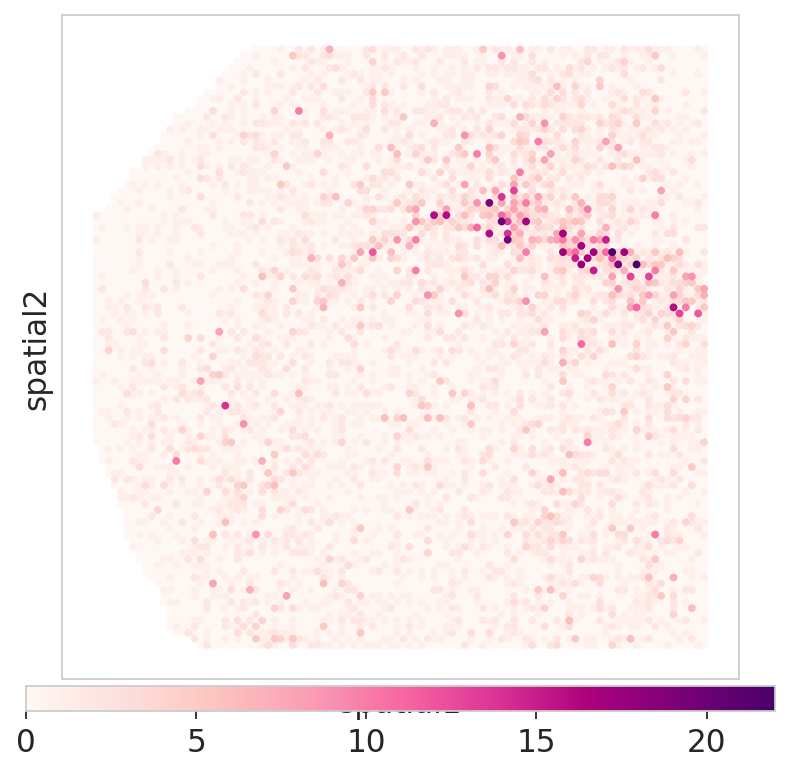

In [31]:
sc.pl.spatial(
    use_raw=False,
    adata=model.adata, #[model.adata.obs["sample"] == "embryo2"],
    color="Nfasc", # "Fgfr1",
    color_map="RdPu",
    spot_size=spot_size,
    title=f"",
    legend_loc=None,
    colorbar_loc="bottom",
    show=True)

In [ ]:
fig, axs = plt.subplots(nrows=2,
                                ncols=2,
                                figsize=(15, 15))

# Lmo4 TF & Target Gene Peaks
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color="Fzd6",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Fzd3",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 0],
    show=False)    
color_map = "RdPu"
sc.pl.spatial(
    adata=model.adata[model.adata.obs["sample"] == "embryo2"],
    color="Nog",
    color_map=color_map,
    spot_size=spot_size,
    title=f"Nog",
    legend_loc=None,
    colorbar_loc="bottom",
    ax=axs[0, 1],
    show=False)

In [ ]:
model.adata.obs["Ihh_ligand_receptor_target_gene_GP"]

In [ ]:
# Plot cell types in latent and physical space
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    color_palette="cell_type_30",
    cat_key=cell_type_key)

if dataset == "spatial_atac_rna_seq_mouse_brain_batch2":
    cell_type_colors["CA3GL"] = "#1f77b4"
    cell_type_colors["D1MSN"] = "#ff7f0e"
    cell_type_colors["LSXGA"] = "#279e68"
    cell_type_colors["MXD"] = "#d62728"
    cell_type_colors["STRGA"] = "#aa40fc"

save_fig = False
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

plot_category_in_latent_and_physical_space(
    adata=model.adata,
    plot_label="Cell Types",
    cat_key=cell_type_key,
    groups=["Splanchnic mesoderm"],
    sample_key=sample_key,
    samples=samples,
    cat_colors=cell_type_colors,
    size=(720000 / len(model.adata)),
    spot_size=spot_size,
    save_fig=save_fig,
    file_path=file_path)